In [127]:
!pip install yfinance
!pip install arch
!pip install wrds
!pip install refinitiv-data
!pip install eikon


In [128]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from arch import arch_model
import wrds
import eikon as ek
import datetime as dt

### Are Inflation and Volatility Orthogonal? 

In [129]:
fred = Fred(api_key='6b4eeb7bacf916c9917c8a74feb0921c')

# Download U.S. CPI data (monthly) from FRED
cpi_data = fred.get_series('CPIAUCSL', observation_start='1978-12-31', observation_end='2024-12-31')

# Convert the CPI data to a DataFrame and set the date as index
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
cpi_df.index = pd.to_datetime(cpi_df.index)

# Calculate the monthly inflation rate
cpi_df['Monthly Inflation Rate'] = cpi_df['CPI'].pct_change() * 100

# Resample to monthly frequency
cpi_df = cpi_df.resample('M').mean()

# Drop any missing values
cpi_df.dropna(inplace=True)

print(cpi_df.head())

             CPI  Monthly Inflation Rate
1979-01-31  68.5                0.883652
1979-02-28  69.2                1.021898
1979-03-31  69.9                1.011561
1979-04-30  70.6                1.001431
1979-05-31  71.4                1.133144


C:\Users\geral\AppData\Local\Temp\ipykernel_15740\4172750302.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpi_df = cpi_df.resample('M').mean()


In [130]:
# Calculate Year-over-Year (YoY) inflation rate
cpi_df['YoY Inflation Rate'] = cpi_df['CPI'].pct_change(periods=12) * 100

# Drop any missing values from the YoY calculation
cpi_df.dropna(inplace=True)

print(cpi_df.head())

             CPI  Monthly Inflation Rate  YoY Inflation Rate
1980-01-31  78.0                1.430429           13.868613
1980-02-29  79.0                1.282051           14.161850
1980-03-31  80.1                1.392405           14.592275
1980-04-30  80.9                0.998752           14.589235
1980-05-31  81.7                0.988875           14.425770


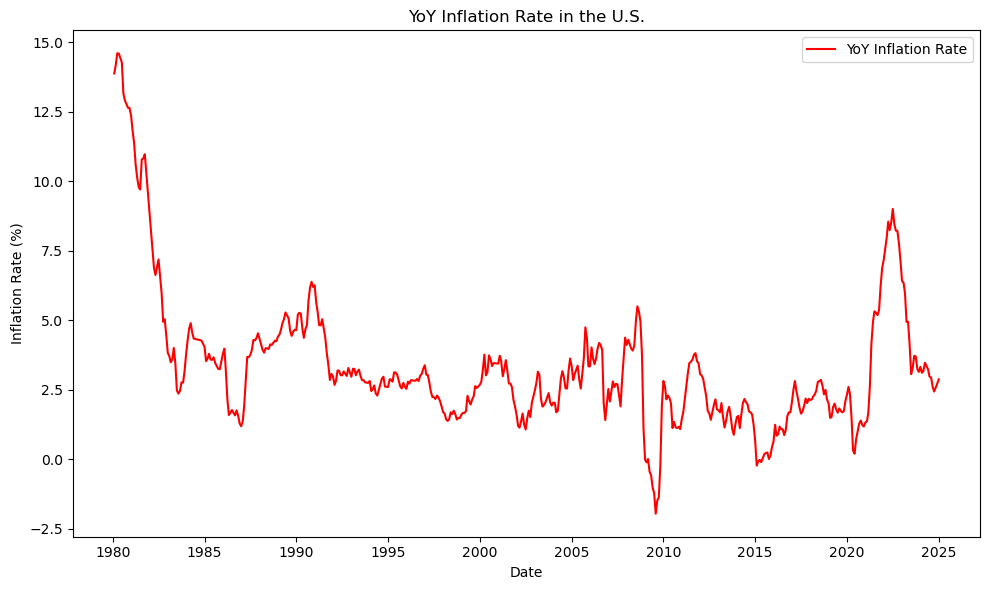

In [131]:
# Plot Monthly Inflation Rate and YoY Inflation Rate
plt.figure(figsize=(10, 6))

# Plot YoY Inflation Rate
plt.plot(cpi_df.index, cpi_df['YoY Inflation Rate'], color='red', label='YoY Inflation Rate')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('YoY Inflation Rate in the U.S.')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [216]:
# Set your Eikon API key
ek.set_app_key('61899440ebae4092ba26deecaf92f2da82521286')

# Define the MSCI World Index RIC (Example: '.dMIWO00000PUS')
msci_ric = '.dMIWO00000PUS'

# Fetch historical monthly data from 1980 to 2024
msci_world = ek.get_timeseries(msci_ric, start_date='1979-01-01', end_date='2024-12-31', interval='monthly')

# Keep only the closing price column
msci_world.rename(columns={'CLOSE': 'Price'}, inplace=True)

# Calculate Monthly Returns
msci_world['Monthly Returns'] = msci_world['Price'].pct_change() * 100

# Display first few rows
print(msci_world.head())

.dMIWO00000PUS     Price  HIGH   LOW  OPEN  Monthly Returns
Date                                                       
1979-01-31      125.0603  <NA>  <NA>  <NA>             <NA>
1979-02-28      122.3527  <NA>  <NA>  <NA>        -2.165036
1979-03-31      127.0677  <NA>  <NA>  <NA>         3.853613
1979-04-30      126.5216  <NA>  <NA>  <NA>        -0.429771
1979-05-31      123.9642  <NA>  <NA>  <NA>        -2.021315


In [217]:
# Keep only the Monthly Returns column
msci_world = msci_world[['Monthly Returns']]

# Calculate Cumulative Monthly Returns
msci_world['Cumulative Returns'] = (1 + msci_world['Monthly Returns'] / 100).cumprod() - 1

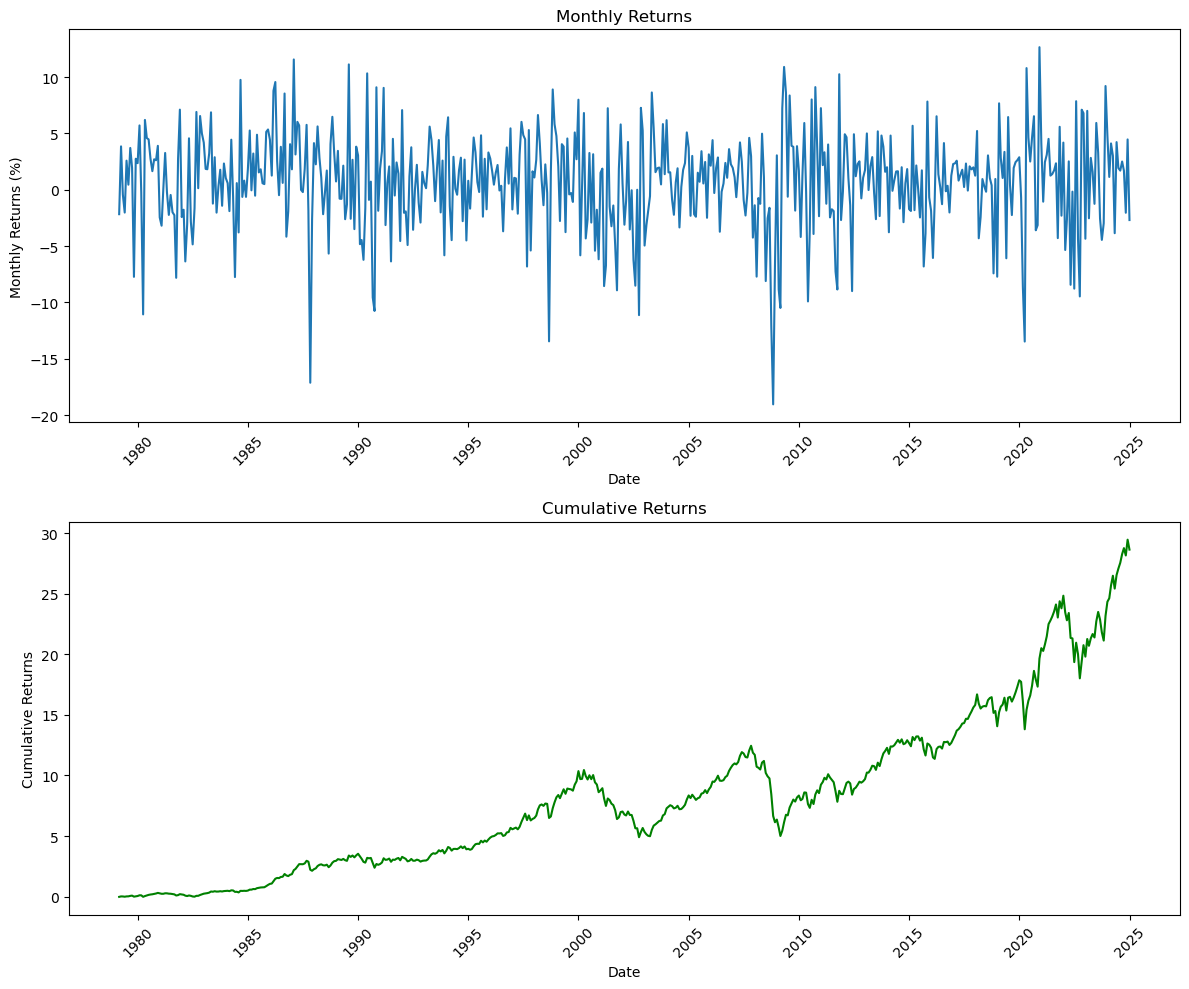

.dMIWO00000PUS  Monthly Returns  Cumulative Returns
Date                                               
1979-01-31                 <NA>                <NA>
1979-02-28            -2.165036            -0.02165
1979-03-31             3.853613            0.016051
1979-04-30            -0.429771            0.011685
1979-05-31            -2.021315           -0.008765


In [218]:
# Plot the returns
title = 'MSCI World Index Monthly and Cumulative Returns (1980-2024)'
fig, ax = plt.subplots(2, 1, figsize=(12,10))

# Monthly Returns Plot
ax[0].plot(msci_world.index, msci_world['Monthly Returns'])
ax[0].set_title('Monthly Returns')
ax[0].set_ylabel('Monthly Returns (%)')
ax[0].set_xlabel('Date')
ax[0].tick_params(axis='x', rotation=45)

# Cumulative Returns Plot
ax[1].plot(msci_world.index, msci_world['Cumulative Returns'], color='green')
ax[1].set_title('Cumulative Returns')
ax[1].set_ylabel('Cumulative Returns')
ax[1].set_xlabel('Date')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display first few rows
print(msci_world.head())

In [219]:
msci_world.dropna(subset=['Monthly Returns'], inplace=True)

msci_world.head()

.dMIWO00000PUS,Monthly Returns,Cumulative Returns
Date,,
1979-02-28,-2.165036,-0.02165
1979-03-31,3.853613,0.016051
1979-04-30,-0.429771,0.011685
1979-05-31,-2.021315,-0.008765
1979-06-30,2.585747,0.016866


In [220]:
# Calculate the historical volatility (standard deviation) of the MSCI World Index returns
msci_world['Historical Volatility'] = msci_world['Monthly Returns'].rolling(window=12).std() * (12 ** 0.5)

In [221]:
# Fit a GARCH(1,1) model to the returns
garch_model = arch_model(msci_world['Monthly Returns'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Get the conditional volatility from the GARCH model
msci_world['GARCH Volatility'] = garch_fit.conditional_volatility


In [222]:
msci_world.head()

.dMIWO00000PUS,Monthly Returns,Cumulative Returns,Historical Volatility,GARCH Volatility
Date,,,,
1979-02-28,-2.165036,-0.02165,NaN,3.911117
1979-03-31,3.853613,0.016051,NaN,3.848258
1979-04-30,-0.429771,0.011685,NaN,3.807190
1979-05-31,-2.021315,-0.008765,NaN,3.632505
1979-06-30,2.585747,0.016866,NaN,3.615174


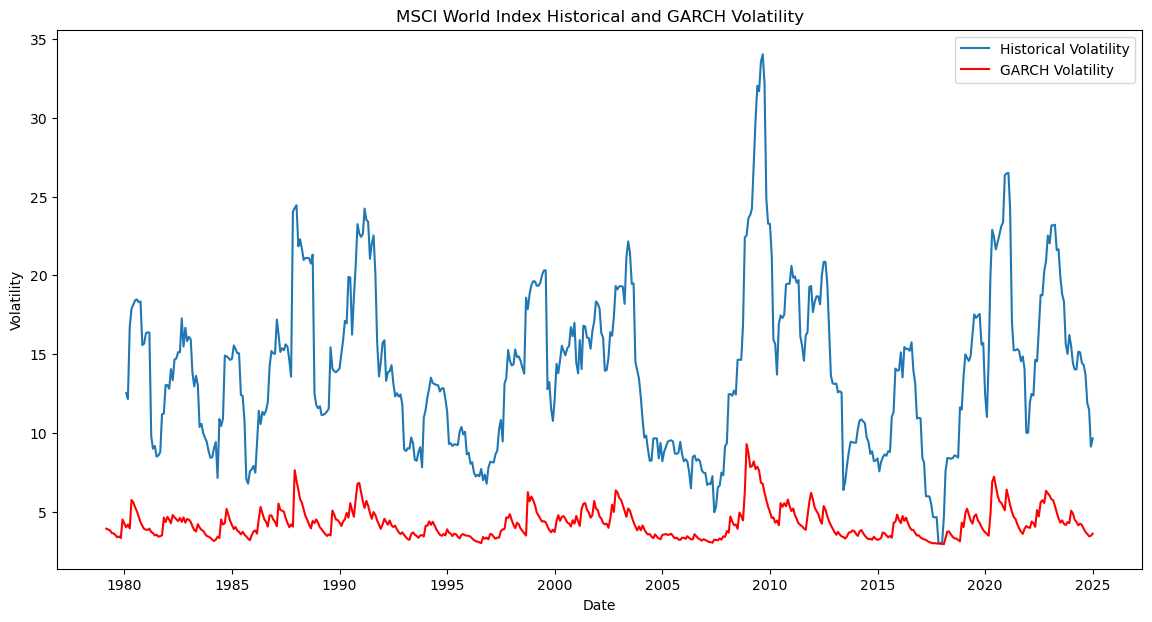

In [223]:
# Plot the volatilities
plt.figure(figsize=(14, 7))
plt.plot(msci_world.index, msci_world['Historical Volatility'], label='Historical Volatility')
plt.plot(msci_world.index, msci_world['GARCH Volatility'], label='GARCH Volatility', color='red')
plt.title('MSCI World Index Historical and GARCH Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [224]:
msci_world.head()

.dMIWO00000PUS,Monthly Returns,Cumulative Returns,Historical Volatility,GARCH Volatility
Date,,,,
1979-02-28,-2.165036,-0.02165,NaN,3.911117
1979-03-31,3.853613,0.016051,NaN,3.848258
1979-04-30,-0.429771,0.011685,NaN,3.807190
1979-05-31,-2.021315,-0.008765,NaN,3.632505
1979-06-30,2.585747,0.016866,NaN,3.615174


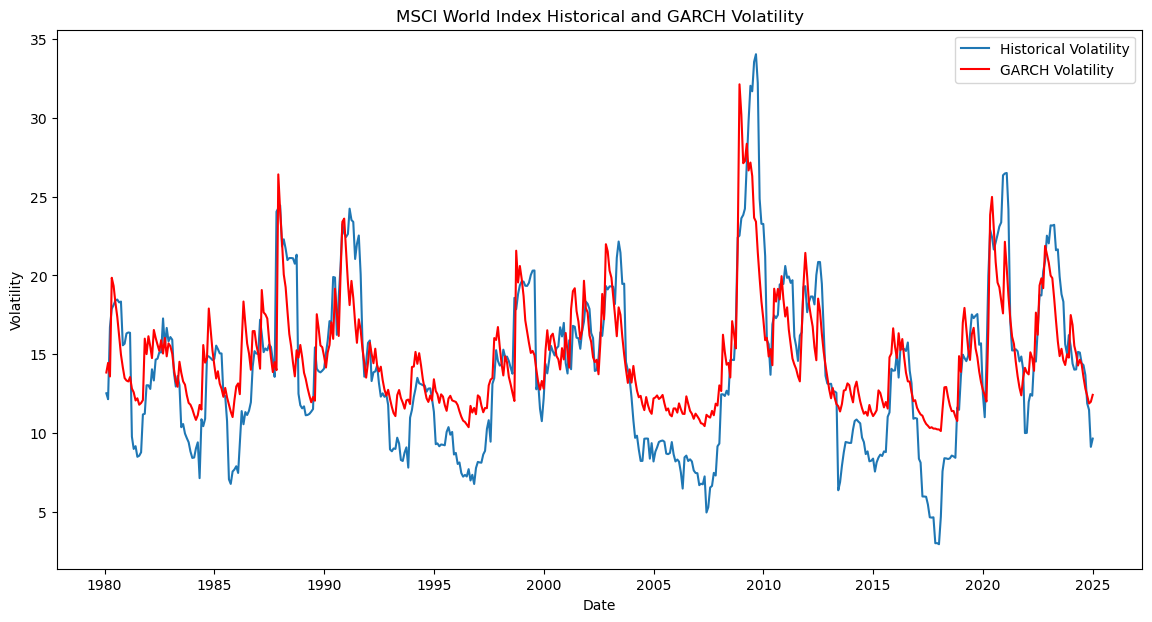

In [225]:
# Calculate Historical Volatility (Rolling 12-month standard deviation)
msci_world['Hist_Volatility'] = msci_world['Monthly Returns'].rolling(window=12).std() * (12 ** 0.5)

# Fit a GARCH(1,1) model to the returns
garch_model = arch_model(msci_world['Monthly Returns'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Get conditional volatility (annualized)
msci_world['GARCH_Volatility'] = garch_fit.conditional_volatility * (12 ** 0.5)

# Drop any remaining NaN values in the volatility columns
msci_world.dropna(subset=['Hist_Volatility', 'GARCH_Volatility'], inplace=True)

# Plot the volatilities
plt.figure(figsize=(14, 7))
plt.plot(msci_world.index, msci_world['Hist_Volatility'], label='Historical Volatility')
plt.plot(msci_world.index, msci_world['GARCH_Volatility'], label='GARCH Volatility', color='red')
plt.title('MSCI World Index Historical and GARCH Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [226]:
# Align the dataframes by their indices
combined_df = pd.concat([cpi_df['YoY Inflation Rate'], msci_world['Hist_Volatility'], msci_world['GARCH_Volatility']], axis=1).dropna()

In [227]:
combined_df.head()

,YoY Inflation Rate,Hist_Volatility,GARCH_Volatility
1980-01-31,13.868613,12.518937,13.837859
1980-02-29,14.161850,12.144582,14.448359
1980-03-31,14.592275,16.723001,13.586766
1980-04-30,14.589235,17.881196,19.849612
1980-05-31,14.425770,18.128626,19.329603


In [228]:

# Calculate the correlation between YoY inflation and both volatilities
correlation_hist = combined_df[['YoY Inflation Rate', 'Hist_Volatility']].corr().iloc[0, 1]
correlation_garch = combined_df[['YoY Inflation Rate', 'GARCH_Volatility']].corr().iloc[0, 1]

print(f"Correlation between YoY Inflation Rate and Historical Volatility: {correlation_hist}")
print(f"Correlation between YoY Inflation Rate and GARCH Volatility: {correlation_garch}")

Correlation between YoY Inflation Rate and Historical Volatility: -0.005882228857326006
Correlation between YoY Inflation Rate and GARCH Volatility: -0.030591387289978914


In [229]:
# Calculate rolling correlation for each month
rolling_corr_hist = combined_df['YoY Inflation Rate'].rolling(window=12).corr(combined_df['Hist_Volatility'])
rolling_corr_garch = combined_df['YoY Inflation Rate'].rolling(window=12).corr(combined_df['GARCH_Volatility'])

In [230]:
# Count the number of months with positive and negative correlations
positive_corr_hist = (rolling_corr_hist > 0).sum()
negative_corr_hist = (rolling_corr_hist < 0).sum()

positive_corr_garch = (rolling_corr_garch > 0).sum()
negative_corr_garch = (rolling_corr_garch < 0).sum()

print(f"Number of months with positive correlation (Historical Volatility): {positive_corr_hist}")
print(f"Number of months with negative correlation (Historical Volatility): {negative_corr_hist}")

print(f"Number of months with positive correlation (GARCH Volatility): {positive_corr_garch}")
print(f"Number of months with negative correlation (GARCH Volatility): {negative_corr_garch}")

Number of months with positive correlation (Historical Volatility): 223
Number of months with negative correlation (Historical Volatility): 306
Number of months with positive correlation (GARCH Volatility): 221
Number of months with negative correlation (GARCH Volatility): 308


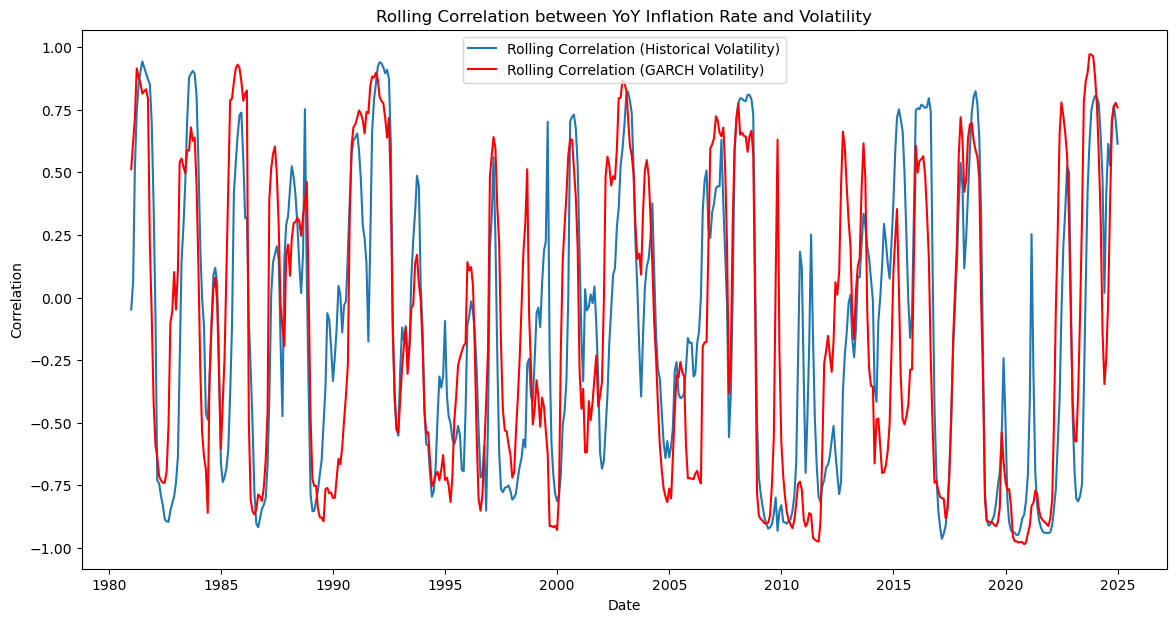

In [231]:
# Plot the rolling correlations
plt.figure(figsize=(14, 7))
plt.plot(rolling_corr_hist, label='Rolling Correlation (Historical Volatility)')
plt.plot(rolling_corr_garch, label='Rolling Correlation (GARCH Volatility)', color='red')
plt.title('Rolling Correlation between YoY Inflation Rate and Volatility')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

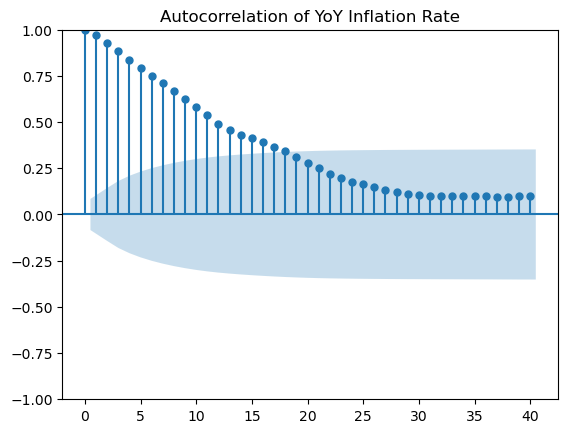

<Figure size 1200x600 with 0 Axes>

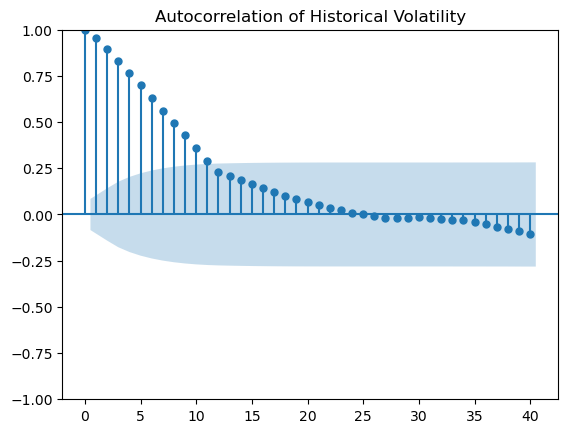

<Figure size 1200x600 with 0 Axes>

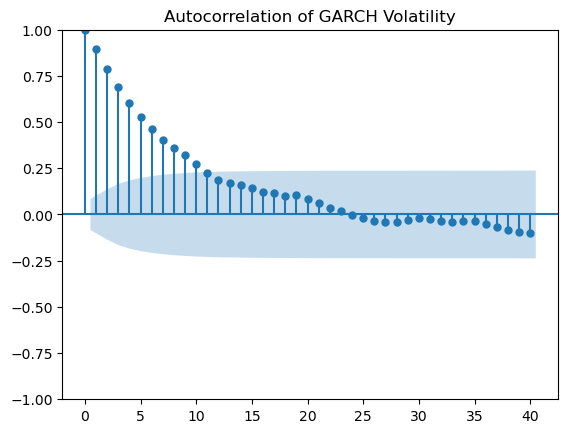

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Assuming cpi_df and msci_world DataFrames are already loaded

# Calculate Historical Volatility and GARCH Volatility if not already present
if 'Historical Volatility' not in msci_world.columns:
    msci_world['Historical Volatility'] = msci_world['Monthly Return'].rolling(window=12).std() * np.sqrt(12) * 100

if 'GARCH Volatility' not in msci_world.columns:
    garch_model = arch_model(msci_world['Monthly Return'], vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')
    msci_world['GARCH Volatility'] = garch_fit.conditional_volatility

# Plot autocorrelation for YoY Inflation Rate
plt.figure(figsize=(12, 6))
plot_acf(cpi_df['YoY Inflation Rate'].dropna(), lags=40, title='Autocorrelation of YoY Inflation Rate')
plt.show()

# Plot autocorrelation for Historical Volatility
plt.figure(figsize=(12, 6))
plot_acf(msci_world['Historical Volatility'].dropna(), lags=40, title='Autocorrelation of Historical Volatility')
plt.show()

# Plot autocorrelation for GARCH Volatility
plt.figure(figsize=(12, 6))
plot_acf(msci_world['GARCH Volatility'].dropna(), lags=40, title='Autocorrelation of GARCH Volatility')
plt.show()

# get expected inflation (professional forecasters survey) and expected volatility (vix world index)

### Descriptive Statistics

 What Assets are we considering? 

 1. S&P500
 2. Russell 2000
 3. Nasdaq
 4. FTSE Index
 5. DAX Index
 6. Stoxx50 Index
 7. Nikkei Index 
 8. Gold
 9. Oil
 10. TIPS
 11. 1 Year Treasury Bill
 12. 10 Year Treasury Bill
 13. REIT O
 14. REIT SPG
 14. USD/EUR
 15. USD/JPY
 16. USD/CHF
 17. Another Commodity?



    sp500_df, russell2000_data, nasdaq_data, FTSE_data, dax_data, stoxx_data, nikkei_data,
    gold_data, oil_data, tips_etf_data, y1_t_bill_df, AMT_data, PLD_data, USD_EUR_data, 
    USD_JPY_data, USD_CHF_data

In [145]:
# Connect to WRDS
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [256]:
# Adjusted query to select S&P 500 returns; omitting `spric` due to undefined column
query = """
    SELECT caldt AS date, sprtrn AS return
    FROM crsp.msp500
    WHERE caldt >= '1980-01-31' AND caldt <= '2024-12-31'
"""
sp500_df = db.raw_sql(query)

# Convert `date` to datetime format for easier handling in pandas
sp500_df['date'] = pd.to_datetime(sp500_df['date'])
sp500_df.set_index('date', inplace=True)

# Display the first few rows of data
print("S&P 500 Monthly Data from CRSP:")
print(sp500_df.head())

S&P 500 Monthly Data from CRSP:
              return
date                
1980-01-31  0.057625
1980-02-29 -0.004380
1980-03-31 -0.101795
1980-04-30  0.041140
1980-05-30  0.046571


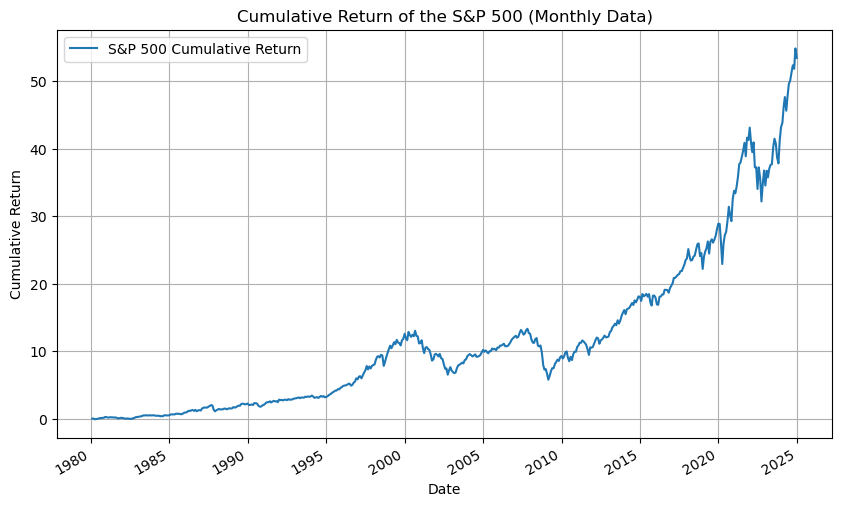

In [257]:
# Rename the columns in sp500_df
sp500_df.rename(columns={'return': 'Monthly Return', 'date': 'Date'}, inplace=True)


# Ensure data is sorted by date
sp500_df.sort_index(inplace=True)

# Calculate cumulative returns (starting from 1, subtract 1 at the end)
sp500_df['Cumulative Return'] = (1 + sp500_df['Monthly Return']).cumprod() - 1

# Plot the cumulative return
plt.figure(figsize=(10, 6))
sp500_df['Cumulative Return'].plot(label="S&P 500 Cumulative Return")
plt.title('Cumulative Return of the S&P 500 (Monthly Data)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [258]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
sp500_df = sp500_df[['Monthly Return', 'Cumulative Return']]

In [259]:
sp500_df = sp500_df.dropna()

In [260]:
sp500_df.head()

,Monthly Return,Cumulative Return
date,,
1980-01-31,0.057625,0.057625
1980-02-29,-0.004380,0.052993
1980-03-31,-0.101795,-0.054197
1980-04-30,0.041140,-0.015286
1980-05-30,0.046571,0.030573


In [261]:
num_obs = len(sp500_df)
print(f"Number of observations: {num_obs}")

Number of observations: 540


In [148]:
# Set your App Key
ek.set_app_key('61899440ebae4092ba26deecaf92f2da82521286')

# Define the ticker symbol and parameters for the Russell 2000 index
ticker = '.RUT'  # This is the symbol for the Russell 2000 index

# Retrieve monthly (end-of-month) historical data since January 1, 1984
start_date = '1979-12-01'
end_date = '2024-12-31'

# Request data
try:
    # Use the historical data function with monthly intervals
    russell2000_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'  # Retrieves end-of-month data points
    )
    
    # Display the data
    print(russell2000_data)
except Exception as e:
    print(f"An error occurred: {e}")


.RUT             HIGH      CLOSE        LOW       OPEN  VOLUME
Date                                                          
1979-12-31       <NA>      55.52       <NA>       <NA>    <NA>
1980-01-31       <NA>      60.08       <NA>       <NA>    <NA>
1980-02-29       <NA>      58.81       <NA>       <NA>    <NA>
1980-03-31       <NA>      47.93       <NA>       <NA>    <NA>
1980-04-30       <NA>      50.82       <NA>       <NA>    <NA>
...               ...        ...        ...        ...     ...
2024-08-31  2262.7279  2217.6334  1993.2718  2253.4953    <NA>
2024-09-30  2259.2494    2229.97   2058.684  2206.4118    <NA>
2024-10-31  2289.4888  2196.6525  2170.6131  2223.1187    <NA>
2024-11-30  2466.4854  2434.7257  2200.2976    2202.18    <NA>
2024-12-31  2442.6064  2230.1582  2194.8966  2437.2084    <NA>

[541 rows x 5 columns]


In [149]:
# Calculate monthly returns as percentage change
russell2000_data['Monthly Return'] = russell2000_data['CLOSE'].pct_change()
    
# Calculate cumulative returns
russell2000_data['Cumulative Return'] = (1 + russell2000_data['Monthly Return']).cumprod() - 1
    
# Display the results
print(russell2000_data[['CLOSE', 'Monthly Return', 'Cumulative Return']])

.RUT            CLOSE  Monthly Return  Cumulative Return
Date                                                    
1979-12-31      55.52            <NA>               <NA>
1980-01-31      60.08        0.082133           0.082133
1980-02-29      58.81       -0.021138           0.059258
1980-03-31      47.93       -0.185003          -0.136707
1980-04-30      50.82        0.060296          -0.084654
...               ...             ...                ...
2024-08-31  2217.6334       -0.016346          38.942965
2024-09-30    2229.97        0.005563          39.165166
2024-10-31  2196.6525       -0.014941          38.565067
2024-11-30  2434.7257         0.10838          42.853129
2024-12-31  2230.1582       -0.084021          39.168555

[541 rows x 3 columns]


In [150]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
russell2000_data = russell2000_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
russell2000_data.index.name = 'Date'

# Drop rows with missing values
russell2000_data = russell2000_data.dropna()

# Display the updated DataFrame
print(russell2000_data)

.RUT        Monthly Return  Cumulative Return
Date                                         
1980-01-31        0.082133           0.082133
1980-02-29       -0.021138           0.059258
1980-03-31       -0.185003          -0.136707
1980-04-30        0.060296          -0.084654
1980-05-31        0.079693          -0.011707
...                    ...                ...
2024-08-31       -0.016346          38.942965
2024-09-30        0.005563          39.165166
2024-10-31       -0.014941          38.565067
2024-11-30         0.10838          42.853129
2024-12-31       -0.084021          39.168555

[540 rows x 2 columns]


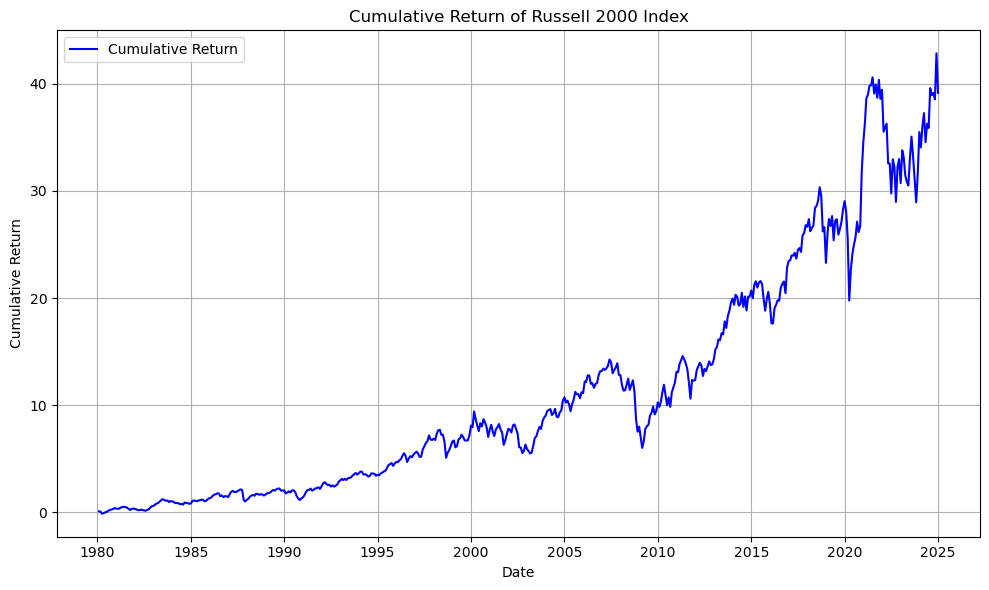

In [268]:
# Plotting the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(russell2000_data.index, russell2000_data['Cumulative Return'], label='Cumulative Return', color='b')
plt.title('Cumulative Return of Russell 2000 Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [152]:

# Define the ticker symbol for NASDAQ and parameters
ticker = '.IXIC'  # NASDAQ Composite index
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    nasdaq_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    
    # Calculate monthly returns as percentage change
    nasdaq_data['Monthly Return'] = nasdaq_data['CLOSE'].pct_change()
    
    # Calculate cumulative returns
    nasdaq_data['Cumulative Return'] = (1 + nasdaq_data['Monthly Return']).cumprod() - 1
      
    
except Exception as e:
    print(f"An error occurred: {e}")
 
print(nasdaq_data)

.IXIC            HIGH      CLOSE        LOW       OPEN         VOLUME  \
Date                                                                    
1980-03-31       <NA>      131.0       <NA>       <NA>           <NA>   
1980-04-30       <NA>    139.989       <NA>       <NA>           <NA>   
1980-05-31       <NA>    150.449       <NA>       <NA>           <NA>   
1980-06-30       <NA>    157.779       <NA>       <NA>           <NA>   
1980-07-31       <NA>    171.809       <NA>       <NA>           <NA>   
...               ...        ...        ...        ...            ...   
2024-08-31  18017.689  17713.624  15708.537  17647.032  26767776735.0   
2024-09-30   18327.34   18189.17  16668.572  17585.449  23206013904.0   
2024-10-31  18785.495  18095.151  17767.791  18154.939  23323636617.0   
2024-11-30  19366.069  19218.166   18112.83  18189.667  25038500713.0   
2024-12-31  20204.581  19310.792  19168.382  19255.425  29491769366.0   

.IXIC       Monthly Return  Cumulative Return  
Da

c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [153]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
nasdaq_data = nasdaq_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
nasdaq_data.index.name = 'Date'

nasdaq_data = nasdaq_data.dropna()

# Display the updated DataFrame
print(nasdaq_data)

.IXIC       Monthly Return  Cumulative Return
Date                                         
1980-04-30        0.068618           0.068618
1980-05-31         0.07472           0.148466
1980-06-30        0.048721            0.20442
1980-07-31        0.088922           0.311519
1980-08-31        0.056516           0.385641
...                    ...                ...
2024-08-31         0.00649         134.218504
2024-09-30        0.026846         137.848626
2024-10-31       -0.005169         137.130924
2024-11-30        0.062062         145.703557
2024-12-31         0.00482         146.410626

[537 rows x 2 columns]


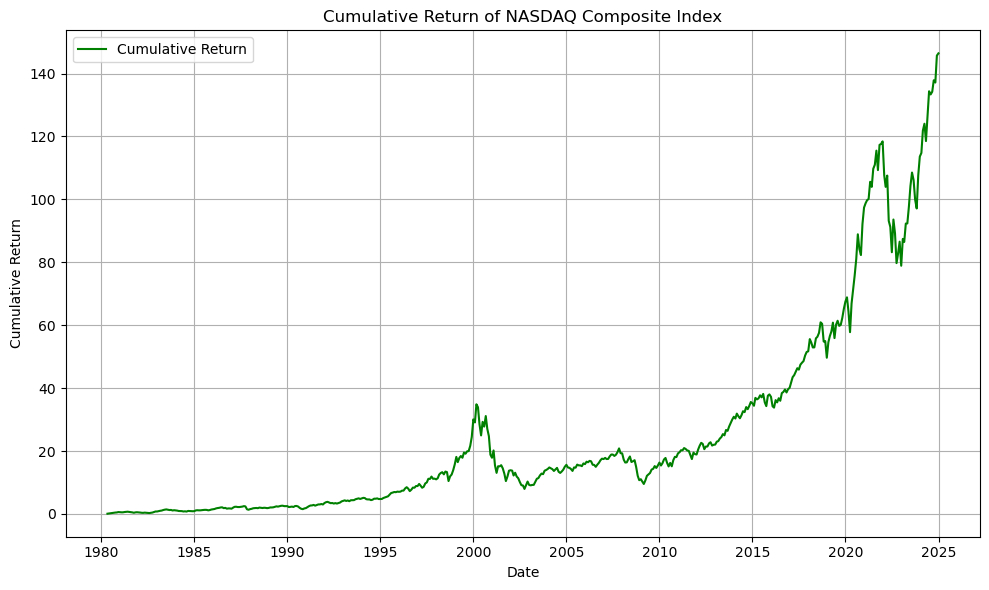

In [154]:
    # Plotting the cumulative returns for NASDAQ
    plt.figure(figsize=(10, 6))
    plt.plot(nasdaq_data.index, nasdaq_data['Cumulative Return'], label='Cumulative Return', color='g')
    plt.title('Cumulative Return of NASDAQ Composite Index')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [155]:
# Define the ticker symbol for the FTSE 100 index and parameters
ticker = '.FTSE'  # FTSE 1000 index symbol
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    FTSE_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print(FTSE_data.head())  # Print the first few rows of the data

except Exception as e:
    print(f"An error occurred: {e}")

.FTSE         HIGH   CLOSE     LOW  OPEN  VOLUME
Date                                            
1984-01-31  1082.0  1063.0   993.3  <NA>    <NA>
1984-02-29  1062.6  1040.3  1010.0  <NA>    <NA>
1984-03-31  1131.3  1112.5  1042.1  <NA>    <NA>
1984-04-30  1138.3  1138.3  1090.0  <NA>    <NA>
1984-05-31  1142.8  1021.0  1008.2  <NA>    <NA>


c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [156]:
# Calculate Cumulative Returns
FTSE_data['Price'] = FTSE_data['CLOSE']  # Assuming 'CLOSE' is the column with closing prices

# Calculate percentage change (returns)
FTSE_data['Monthly Return'] = FTSE_data['Price'].pct_change()

# Calculate cumulative return (compounded)
FTSE_data['Cumulative Return'] = (1 + FTSE_data['Monthly Return']).cumprod() - 1

print(FTSE_data)

.FTSE          HIGH    CLOSE      LOW     OPEN         VOLUME    Price  \
Date                                                                     
1984-01-31   1082.0   1063.0    993.3     <NA>           <NA>   1063.0   
1984-02-29   1062.6   1040.3   1010.0     <NA>           <NA>   1040.3   
1984-03-31   1131.3   1112.5   1042.1     <NA>           <NA>   1112.5   
1984-04-30   1138.3   1138.3   1090.0     <NA>           <NA>   1138.3   
1984-05-31   1142.8   1021.0   1008.2     <NA>           <NA>   1021.0   
...             ...      ...      ...      ...            ...      ...   
2024-08-31  8414.37  8376.63  7915.94  8367.98  17928209678.0  8376.63   
2024-09-30  8380.98  8236.95  8168.42  8376.63  16738909178.0  8236.95   
2024-10-31  8395.58   8110.1  8071.72  8236.95  18650596194.0   8110.1   
2024-11-30  8307.27   8287.3  7995.87   8110.1  17707968777.0   8287.3   
2024-12-31  8388.37  8173.02  8002.34   8287.3  14581691624.0  8173.02   

.FTSE       Monthly Return  Cumulativ

In [157]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
FTSE_data = FTSE_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
FTSE_data.index.name = 'Date'

FTSE_data = FTSE_data.dropna()

# Display the updated DataFrame
print(FTSE_data)

.FTSE       Monthly Return  Cumulative Return
Date                                         
1984-02-29       -0.021355          -0.021355
1984-03-31        0.069403           0.046566
1984-04-30        0.023191           0.070837
1984-05-31       -0.103048          -0.039511
1984-06-30         0.01998           -0.02032
...                    ...                ...
2024-08-31        0.001034           6.880179
2024-09-30       -0.016675           6.748777
2024-10-31         -0.0154           6.629445
2024-11-30        0.021849           6.796143
2024-12-31        -0.01379           6.688636

[491 rows x 2 columns]


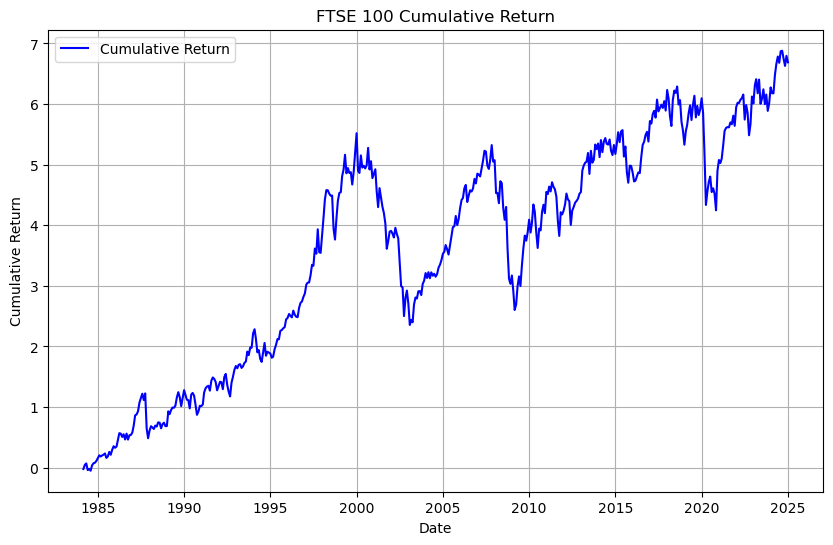

In [158]:
# Plot the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(FTSE_data.index, FTSE_data['Cumulative Return'], label='Cumulative Return', color='blue')
plt.title('FTSE 100 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [159]:
# Define the ticker symbol for DAX 40 index and parameters
ticker = '.GDAXI'  # DAX 40 index symbol (often used in financial data services)
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    dax_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(dax_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully retrieved
.GDAXI      HIGH    CLOSE   LOW  OPEN  VOLUME
Date                                         
1987-12-31  <NA>  1005.19  <NA>  <NA>    <NA>
1988-01-31  <NA>    936.0  <NA>  <NA>    <NA>
1988-02-29  <NA>  1083.34  <NA>  <NA>    <NA>
1988-03-31  <NA>  1062.33  <NA>  <NA>    <NA>
1988-04-30  <NA>  1049.17  <NA>  <NA>    <NA>


c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [160]:
# Calculate Cumulative Returns
dax_data['Price'] = dax_data['CLOSE']  # Assuming 'CLOSE' is the column with closing prices

# Calculate percentage change (returns)
dax_data['Monthly Return'] = dax_data['Price'].pct_change()

# Calculate cumulative return (compounded)
dax_data['Cumulative Return'] = (1 + dax_data['Monthly Return']).cumprod() - 1

print(dax_data)

.GDAXI          HIGH     CLOSE       LOW      OPEN        VOLUME     Price  \
Date                                                                         
1987-12-31      <NA>   1005.19      <NA>      <NA>          <NA>   1005.19   
1988-01-31      <NA>     936.0      <NA>      <NA>          <NA>     936.0   
1988-02-29      <NA>   1083.34      <NA>      <NA>          <NA>   1083.34   
1988-03-31      <NA>   1062.33      <NA>      <NA>          <NA>   1062.33   
1988-04-30      <NA>   1049.17      <NA>      <NA>          <NA>   1049.17   
...              ...       ...       ...       ...           ...       ...   
2024-08-31  18970.71  18906.92  17024.82   18432.5  1019460657.0  18906.92   
2024-09-30  19491.93  19324.93  18208.84  18913.53  1393399482.0  19324.93   
2024-10-31  19674.68  19077.54  18911.72  19409.39  1217257240.0  19077.54   
2024-11-30  19640.15  19626.45  18812.53  19093.99  1415336553.0  19626.45   
2024-12-31  20522.82  19909.14   19568.5  19586.17  1114142924.0

In [161]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
dax_data = dax_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
dax_data.index.name = 'Date'

dax_data = dax_data.dropna()

# Display the updated DataFrame
print(dax_data)

.GDAXI      Monthly Return  Cumulative Return
Date                                         
1988-01-31       -0.068833          -0.068833
1988-02-29        0.157415           0.077746
1988-03-31       -0.019394           0.056845
1988-04-30       -0.012388           0.043753
1988-05-31        0.025249           0.070106
...                    ...                ...
2024-08-31        0.021518            17.8093
2024-09-30        0.022109          18.225151
2024-10-31       -0.012802          17.979039
2024-11-30        0.028773          18.525115
2024-12-31        0.014404          18.806345

[444 rows x 2 columns]


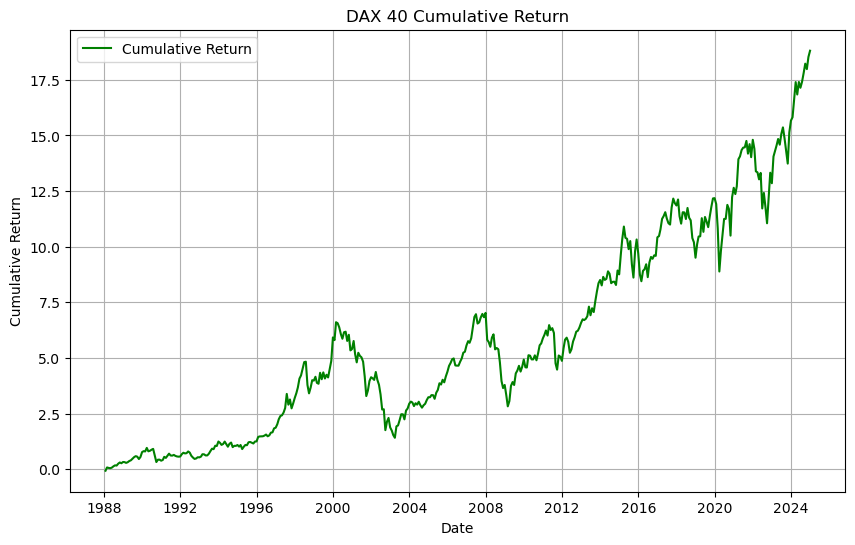

In [162]:
# Plot the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(dax_data.index, dax_data['Cumulative Return'], label='Cumulative Return', color='green')
plt.title('DAX 40 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [163]:
# Define the ticker symbol for the Euro Stoxx 50 index and parameters
ticker = '.STOXX50E'  # Euro Stoxx 50 index symbol in many financial data sources
start_date = '1979-12-01'
end_date = '2024-01-01'

# Retrieve monthly (end-of-month) historical data
try:
    stoxx_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(stoxx_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully retrieved
.STOXX50E     HIGH   CLOSE     LOW    OPEN  VOLUME
Date                                              
1986-12-31  900.82  900.82  900.82  900.82    <NA>
1987-01-31  902.32  859.08   838.6  900.82    <NA>
1987-02-28  849.03  840.97  833.03  849.03    <NA>
1987-03-31  882.89  869.44  836.22   842.7    <NA>
1987-04-30  900.79  881.46  871.69  883.95    <NA>


c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [164]:
# Calculate Cumulative Returns
stoxx_data['Price'] = stoxx_data['CLOSE']  # Assuming 'CLOSE' is the column with closing prices

# Calculate percentage change (returns)
stoxx_data['Monthly Return'] = stoxx_data['Price'].pct_change()

# Calculate cumulative return (compounded)
stoxx_data['Cumulative Return'] = (1 + stoxx_data['Monthly Return']).cumprod() - 1

In [165]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
stoxx_data = stoxx_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
stoxx_data.index.name = 'Date'

stoxx_data = stoxx_data.dropna()

# Display the updated DataFrame
print(stoxx_data)

.STOXX50E   Monthly Return  Cumulative Return
Date                                         
1987-01-31       -0.046336          -0.046336
1987-02-28       -0.021081          -0.066439
1987-03-31        0.033854          -0.034835
1987-04-30        0.013825          -0.021492
1987-05-31       -0.017074          -0.038199
...                    ...                ...
2023-08-31       -0.038959            3.77022
2023-09-30       -0.028496           3.634289
2023-10-31       -0.027197           3.508248
2023-11-30        0.079128           3.864979
2023-12-31         0.03171           4.019249

[444 rows x 2 columns]


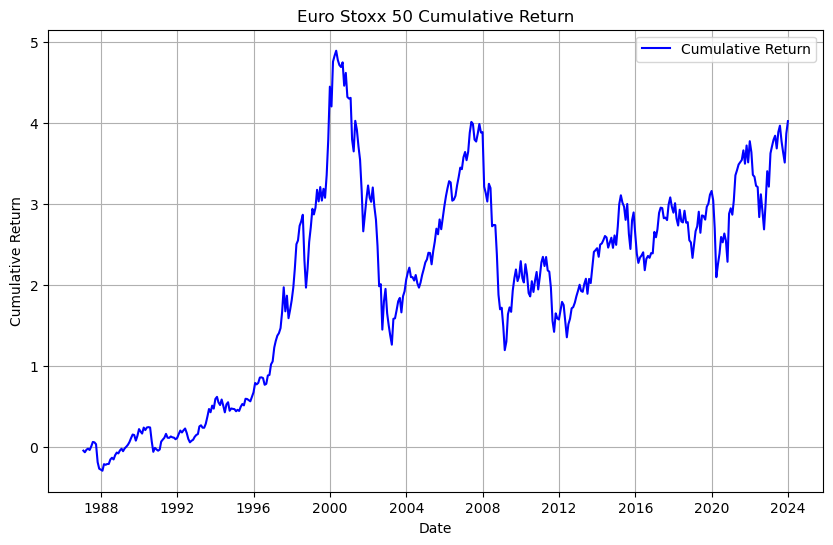

In [166]:
# Plot the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(stoxx_data.index, stoxx_data['Cumulative Return'], label='Cumulative Return', color='blue')
plt.title('Euro Stoxx 50 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [167]:
# List available tables in the 'compd' library
tables = db.list_tables(library='comp')
print("Available tables in compd library:", tables)

Available tables in compd library: ['aco_amda', 'aco_imda', 'aco_indfnta', 'aco_indfntq', 'aco_indfntytd', 'aco_indsta', 'aco_indstq', 'aco_indstytd', 'aco_notesa', 'aco_notesq', 'aco_notessa', 'aco_notesytd', 'aco_pnfnda', 'aco_pnfndq', 'aco_pnfndytd', 'aco_pnfnta', 'aco_pnfntq', 'aco_pnfntytd', 'aco_transa', 'aco_transq', 'aco_transsa', 'aco_transytd', 'adsprate', 'asec_amda', 'asec_imda', 'asec_notesa', 'asec_notesq', 'asec_transa', 'asec_transq', 'bank_aacctchg', 'bank_adesind', 'bank_afnd1', 'bank_afnd2', 'bank_afnddc1', 'bank_afnddc2', 'bank_afntind', 'bank_funda', 'bank_funda_fncd', 'bank_fundq', 'bank_fundq_fncd', 'bank_iacctchg', 'bank_idesind', 'bank_ifndq', 'bank_ifndytd', 'bank_ifntq', 'bank_ifntytd', 'bank_names', 'bank_namesq', 'chars', 'co_aacctchg', 'co_aaudit', 'co_acthist', 'co_adesind', 'co_adjfact', 'co_afnd1', 'co_afnd2', 'co_afnddc1', 'co_afnddc2', 'co_afntind1', 'co_afntind2', 'co_ainvval', 'co_amkt', 'co_busdescl', 'co_cotype', 'co_filedate', 'co_fortune', 'co_h

In [168]:

# Define the query to get data for the Nikkei 225 index from Compustat
query = """
    SELECT
        id_table.tic,
        comp_global_daily.g_idx_mth.datadate AS date,
        id_table.gvkeyx,
        comp_global_daily.g_idx_mth.prccm AS price
    FROM comp_global_daily.g_idx_mth
    INNER JOIN (
        SELECT
            tic,
            gvkeyx
        FROM comp_global_daily.g_names_ix
        WHERE comp_global_daily.g_names_ix.tic IN (
            'I2JPN006'
        )
    ) AS id_table 
    ON comp_global_daily.g_idx_mth.gvkeyx = id_table.gvkeyx
    WHERE comp_global_daily.g_idx_mth.datadate BETWEEN
        '1985-12-01'::date AND '2024-12-31'::date
"""
nikkei_data = db.raw_sql(query)

# Check if the DataFrame is empty
if nikkei_data.empty:
    print("No data found for the specified query.")
else:
    # Convert `date` to datetime format for easier handling in pandas
    nikkei_data['date'] = pd.to_datetime(nikkei_data['date'])
    nikkei_data.set_index('date', inplace=True)

    # Drop rows with missing values
    nikkei_data_cleaned = nikkei_data.dropna()

    # Display the cleaned data
    print("Nikkei 225 Monthly Data from Compustat:")
    print(nikkei_data_cleaned.head())

Nikkei 225 Monthly Data from Compustat:
                 tic  gvkeyx     price
date                                  
1985-12-31  I2JPN006  150069  13083.18
1986-01-31  I2JPN006  150069  13024.30
1986-02-28  I2JPN006  150069  13640.83
1986-03-31  I2JPN006  150069  15859.69
1986-04-30  I2JPN006  150069  15825.50


In [169]:
# Calculate monthly returns
nikkei_data['Monthly Return'] = nikkei_data['price'].pct_change()

# Calculate cumulative returns
nikkei_data['Cumulative Return'] = (1 + nikkei_data['Monthly Return']).cumprod() - 1

# Drop rows with missing values in 'Monthly Return'
nikkei_data.dropna(subset=['Monthly Return'], inplace=True)

# Display the data with cumulative return
print(nikkei_data[['price', 'Monthly Return', 'Cumulative Return']].head())

               price  Monthly Return  Cumulative Return
date                                                   
1986-01-31  13024.30       -0.004500          -0.004500
1986-02-28  13640.83        0.047337           0.042623
1986-03-31  15859.69        0.162663           0.212220
1986-04-30  15825.50       -0.002156           0.209607
1986-05-31  16670.77        0.053412           0.274214


In [170]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
nikkei_data = nikkei_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
nikkei_data.index.name = 'Date'

# Display the updated DataFrame
print(nikkei_data)

            Monthly Return  Cumulative Return
Date                                         
1986-01-31       -0.004500          -0.004500
1986-02-28        0.047337           0.042623
1986-03-31        0.162663           0.212220
1986-04-30       -0.002156           0.209607
1986-05-31        0.053412           0.274214
...                    ...                ...
2024-08-31       -0.011613           1.954003
2024-09-30       -0.018842           1.898344
2024-10-31        0.030636           1.987137
2024-11-30       -0.022344           1.920393
2024-12-31        0.044140           2.049300

[468 rows x 2 columns]


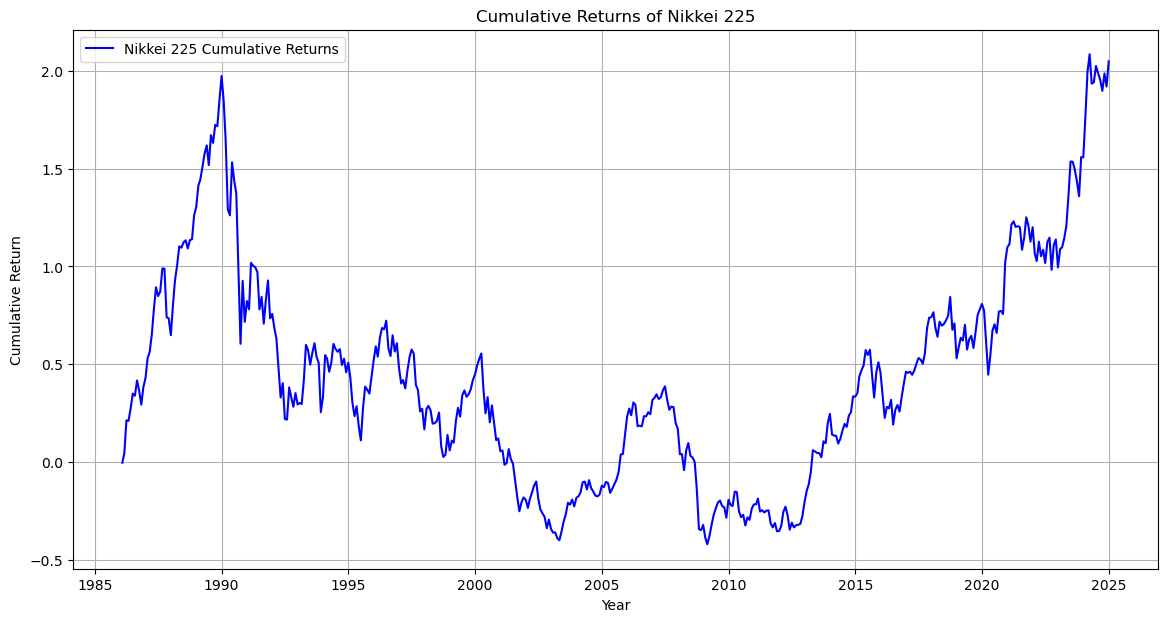

In [171]:
# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(nikkei_data.index, nikkei_data['Cumulative Return'], label='Nikkei 225 Cumulative Returns', color='b')
plt.title('Cumulative Returns of Nikkei 225')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [172]:
# Define the ticker symbol for Realty Income Corp and parameters
ticker = 'O'
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    realty_income_data = ek.get_timeseries(
        ticker,
        fields='CLOSE',
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(realty_income_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully retrieved
O              CLOSE
Date                
1994-10-31  8.049667
1994-11-30  7.747048
1994-12-31  8.291762
1995-01-31  8.594381
1995-02-28   9.19962


In [173]:
# Define the ticker symbol for Simon Property Group and parameters
ticker = 'SPG'
start_date = '1979-12-01'
end_date = '2024-01-01'

# Retrieve monthly (end-of-month) historical data
try:
    spg_data = ek.get_timeseries(
        ticker,
        fields='CLOSE',
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(spg_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")



Data successfully retrieved
SPG             CLOSE
Date                 
1993-12-31  20.312647
1994-01-31  21.996016
1994-02-28  23.118261
1994-03-31  23.006037
1994-04-30  24.016058


In [174]:
# Compute monthly returns
spg_data['Monthly Return'] = spg_data['CLOSE'].pct_change()
realty_income_data['Monthly Return'] = realty_income_data['CLOSE'].pct_change()

# Compute cumulative returns
spg_data['Cumulative Return'] = (1 + spg_data['Monthly Return']).cumprod() - 1
realty_income_data['Cumulative Return'] = (1 + realty_income_data['Monthly Return']).cumprod() - 1

spg_data.head()



SPG,CLOSE,Monthly Return,Cumulative Return
Date,,,
1993-12-31,20.312647,<NA>,<NA>
1994-01-31,21.996016,0.082873,0.082873
1994-02-28,23.118261,0.05102,0.138122
1994-03-31,23.006037,-0.004854,0.132597
1994-04-30,24.016058,0.043902,0.18232


In [175]:
realty_income_data.head()

O,CLOSE,Monthly Return,Cumulative Return
Date,,,
1994-10-31,8.049667,<NA>,<NA>
1994-11-30,7.747048,-0.037594,-0.037594
1994-12-31,8.291762,0.070313,0.030075
1995-01-31,8.594381,0.036496,0.067669
1995-02-28,9.19962,0.070423,0.142857


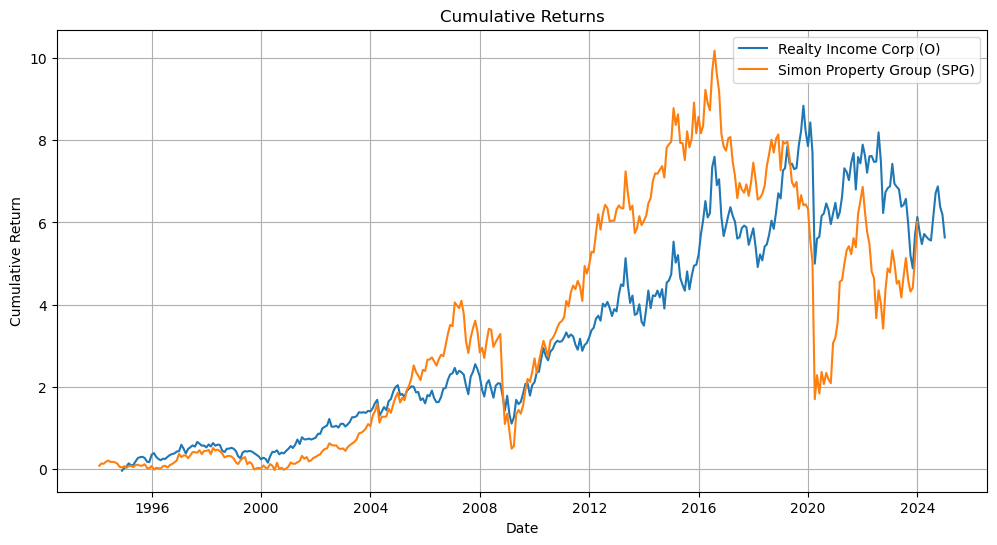

In [176]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(realty_income_data.index, realty_income_data['Cumulative Return'], label='Realty Income Corp (O)')
plt.plot(spg_data.index, spg_data['Cumulative Return'], label='Simon Property Group (SPG)')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [177]:
ticker = 'XAU='  

# Retrieve historical data for gold prices from 1945 to present
gold_data = ek.get_timeseries(ticker, start_date='1979-12-01', end_date='2024-12-31', interval='monthly')

# Ensure data is sorted by date
gold_data.sort_index(inplace=True)

# Calculate Monthly Returns
gold_data['Monthly Return'] = gold_data['CLOSE'].pct_change()

# Calculate Cumulative Returns
gold_data['Cumulative Return'] = (1 + gold_data['Monthly Return']).cumprod()-1

gold_data.head()

XAU=,CLOSE,HIGH,LOW,OPEN,Monthly Return,Cumulative Return
Date,,,,,,
1979-12-31,512.0,515.5,429.0,429.0,<NA>,<NA>
1980-01-31,653.0,835.0,512.0,512.0,0.275391,0.275391
1980-02-29,637.0,710.5,616.5,676.5,-0.024502,0.244141
1980-03-31,495.0,663.75,481.5,663.75,-0.22292,-0.033203
1980-04-30,518.0,554.0,485.75,509.5,0.046465,0.011719


In [178]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
gold_data = gold_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
gold_data.index.name = 'Date'

# Display the updated DataFrame
print(gold_data)

XAU=        Monthly Return  Cumulative Return
Date                                         
1979-12-31            <NA>               <NA>
1980-01-31        0.275391           0.275391
1980-02-29       -0.024502           0.244141
1980-03-31        -0.22292          -0.033203
1980-04-30        0.046465           0.011719
...                    ...                ...
2024-08-31        0.022439           3.888735
2024-09-30        0.052521           4.145496
2024-10-31        0.041492           4.358994
2024-11-30       -0.032895           4.182707
2024-12-31       -0.011205           4.124633

[541 rows x 2 columns]


Text(0.5, 0, 'Year')

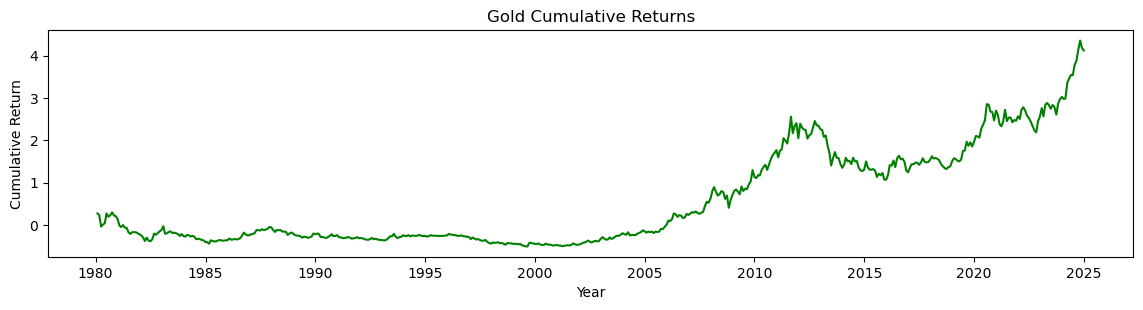

In [179]:
# Plotting the Gold Prices, Monthly Returns, and Cumulative Returns
plt.figure(figsize=(14, 10))


# Plot the cumulative returns
plt.subplot(3, 1, 3)
plt.plot(gold_data.index, gold_data['Cumulative Return'], color='green')
plt.title('Gold Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Year')

In [180]:
# Define the instrument (West Texas Intermediate Oil)
ticker = 'CLc1'  # CLc1 is the RIC for WTI Crude Oil in USD per barrel

# Retrieve historical data for oil prices from 1945 to present
oil_data = ek.get_timeseries(ticker, start_date='1945-01-01', end_date='2024-01-01', interval='monthly')

# Ensure data is sorted by date
oil_data.sort_index(inplace=True)

# Calculate Monthly Returns
oil_data['Monthly Return'] = oil_data['CLOSE'].pct_change()

# Calculate Cumulative Returns
oil_data['Cumulative Return'] = (1 + oil_data['Monthly Return']).cumprod() - 1

# Display the first few rows of the data
oil_data.head()

CLc1,HIGH,LOW,OPEN,CLOSE,VOLUME,Monthly Return,Cumulative Return
Date,,,,,,,
1983-03-31,29.6,29.01,29.25,29.27,1470,<NA>,<NA>
1983-04-30,31.0,29.29,29.3,30.63,5961,0.046464,0.046464
1983-05-31,30.72,29.25,30.66,30.25,4079,-0.012406,0.033481
1983-06-30,31.65,30.1,30.35,31.38,4535,0.037355,0.072087
1983-07-31,32.02,31.0,31.42,32.0,4685,0.019758,0.09327


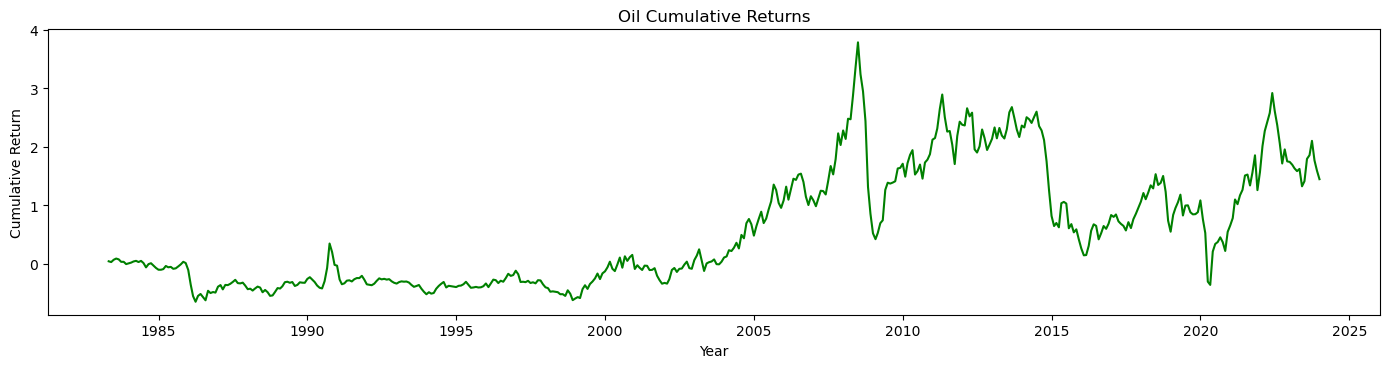

In [181]:
#Plotting the Oil Prices, Monthly Returns, and Cumulative Returns
plt.figure(figsize=(14, 10))


# Plot the cumulative returns
plt.subplot(3, 1, 3)
plt.plot(oil_data.index, oil_data['Cumulative Return'], color='green')
plt.title('Oil Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Year')

plt.tight_layout()
plt.show()

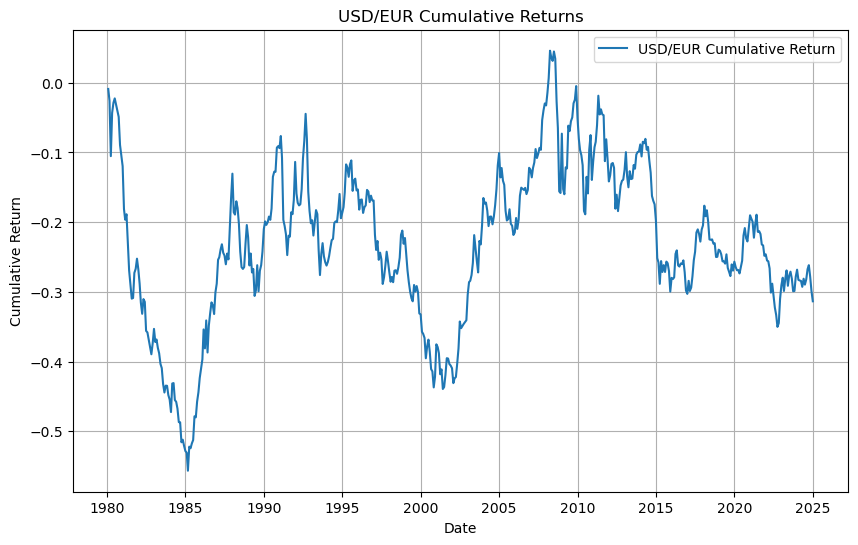

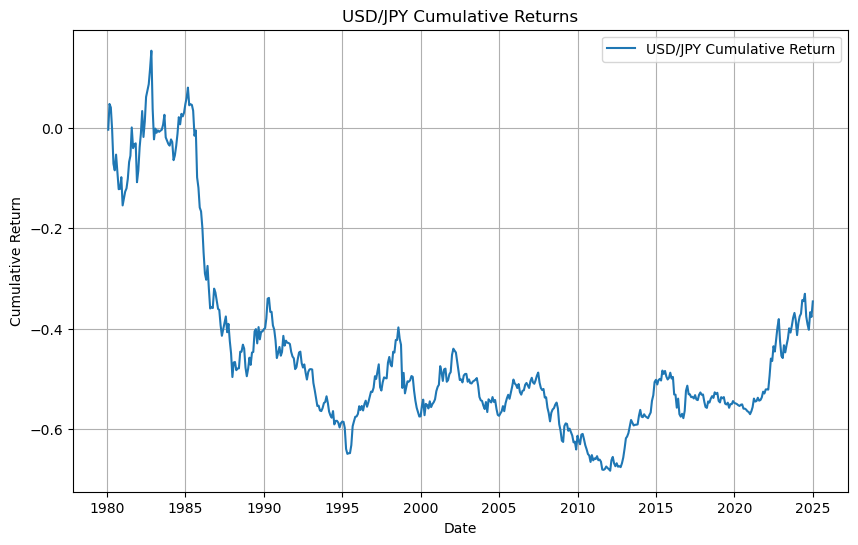

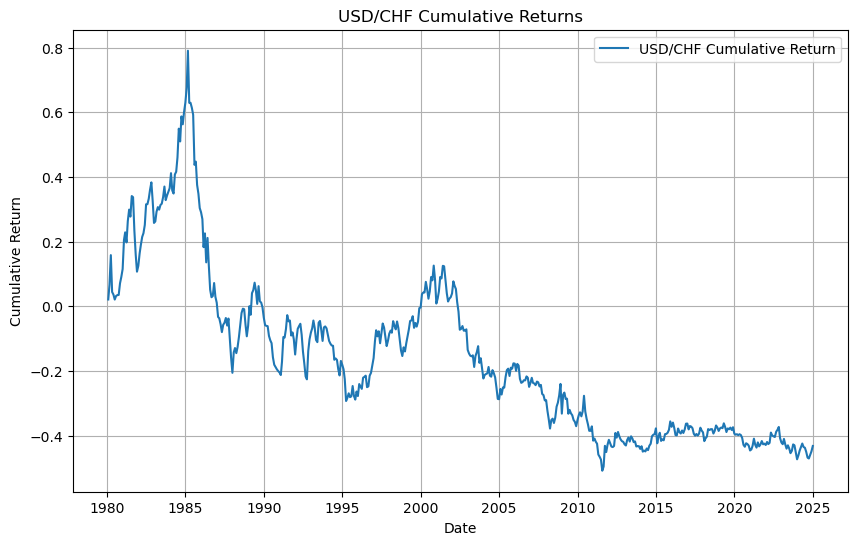

In [182]:

# Define the tickers for FX pairs
tickers = {
    'USD/EUR': 'EUR=',
    'USD/JPY': 'JPY=',
    'USD/CHF': 'CHF='
}

# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Loop through each FX pair, retrieve the data, and calculate returns
for name, ticker in tickers.items():
    # Retrieve FX rate data from Refinitiv
    data = ek.get_timeseries(
        ticker, 
        start_date=start_date, 
        end_date=end_date, 
        interval='monthly'
    )
    data.sort_index(inplace=True)

    # Ensure the data is a DataFrame and calculate monthly and cumulative returns
    data = pd.DataFrame(data)
    data['Monthly Return'] = data['CLOSE'].pct_change()
    data['Cumulative Return'] = (1 + data['Monthly Return']).cumprod()-1

    # Keep only the Date index and the relevant columns
    data = data[['Monthly Return', 'Cumulative Return']]
    
    # Assign the final DataFrame to a dynamically created variable
    globals()[f"{name.replace('/', '_')}_data"] = data

    # Plot the cumulative returns
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Cumulative Return'], label=f'{name} Cumulative Return')
    plt.title(f'{name} Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid()
    plt.show()


C:\Users\geral\AppData\Local\Temp\ipykernel_15740\412552615.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dfii10_data = dfii10_data.resample('M').last()
C:\Users\geral\AppData\Local\Temp\ipykernel_15740\412552615.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfii10_data[series_id].replace(0, 1e-10, inplace=True)


            DFII10  Monthly Return  Cumulative Return
DATE                                                 
2003-01-31    2.19             NaN                NaN
2003-02-28    1.77       -0.191781          -0.191781
2003-03-31    2.03        0.146893          -0.073059
2003-04-30    2.16        0.064039          -0.013699
2003-05-31    1.77       -0.180556          -0.191781


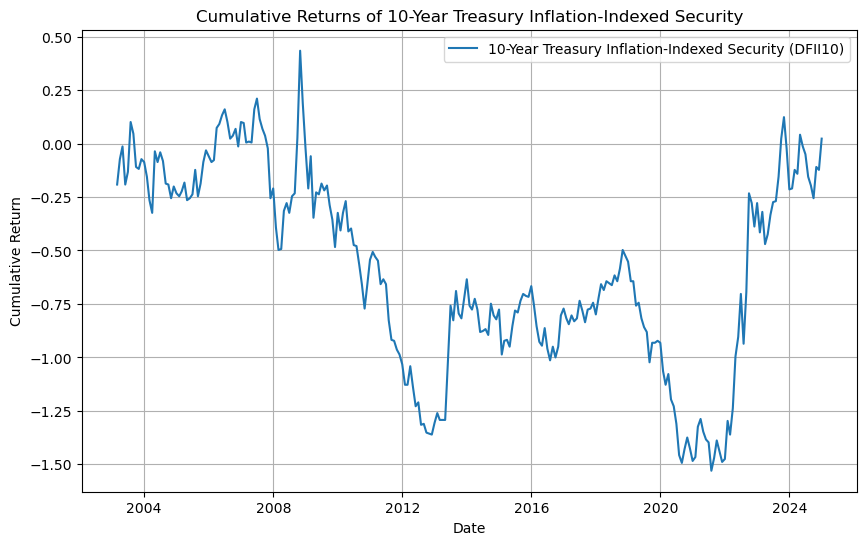

In [183]:
# Define the FRED series ID for the 10-Year Treasury Inflation-Indexed Security
series_id = 'DFII10'

# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Retrieve the data from FRED
dfii10_data = web.DataReader(series_id, 'fred', start_date, end_date)

# Ensure the data is sorted by date
dfii10_data.sort_index(inplace=True)

# Resample to end-of-month data
dfii10_data = dfii10_data.resample('M').last()

# Replace 0 yields with a small value
dfii10_data[series_id].replace(0, 1e-10, inplace=True)

# Calculate Monthly Returns based on yield changes
dfii10_data['Monthly Return'] = dfii10_data[series_id].pct_change()

# Calculate Cumulative Returns
dfii10_data['Cumulative Return'] = (1 + dfii10_data['Monthly Return']).cumprod() - 1

# Display the first few rows of the data
print(dfii10_data.head())

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(dfii10_data.index, dfii10_data['Cumulative Return'], label='10-Year Treasury Inflation-Indexed Security (DFII10)')
plt.title('Cumulative Returns of 10-Year Treasury Inflation-Indexed Security')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

In [184]:
# Define the instrument
ticker = 'TIP'  

tip_etf_data = ek.get_timeseries(ticker, start_date='1979-12-31', end_date='2024-12-31', interval='monthly')

# Ensure data is sorted by date
tip_etf_data.sort_index(inplace=True)

# Calculate Monthly Returns
tip_etf_data['Monthly Return'] = tip_etf_data['CLOSE'].pct_change()

# Calculate Cumulative Returns
tip_etf_data['Cumulative Return'] = (1 + tip_etf_data['Monthly Return']).cumprod() - 1

# Display the first few rows of the data
tip_etf_data.head()

TIP,HIGH,CLOSE,LOW,OPEN,COUNT,VOLUME,Monthly Return,Cumulative Return
Date,,,,,,,,
2003-12-31,102.34,101.71,101.47,101.5,<NA>,1814700,<NA>,<NA>
2004-01-31,103.72,102.95,101.08,101.5,<NA>,3035200,0.012192,0.012192
2004-02-29,105.22,105.16,102.81,102.98,<NA>,2811400,0.021467,0.03392
2004-03-31,107.67,106.91,105.02,105.47,<NA>,3088300,0.016641,0.051126
2004-04-30,106.43,101.26,100.8,106.25,<NA>,2343900,-0.052848,-0.004424


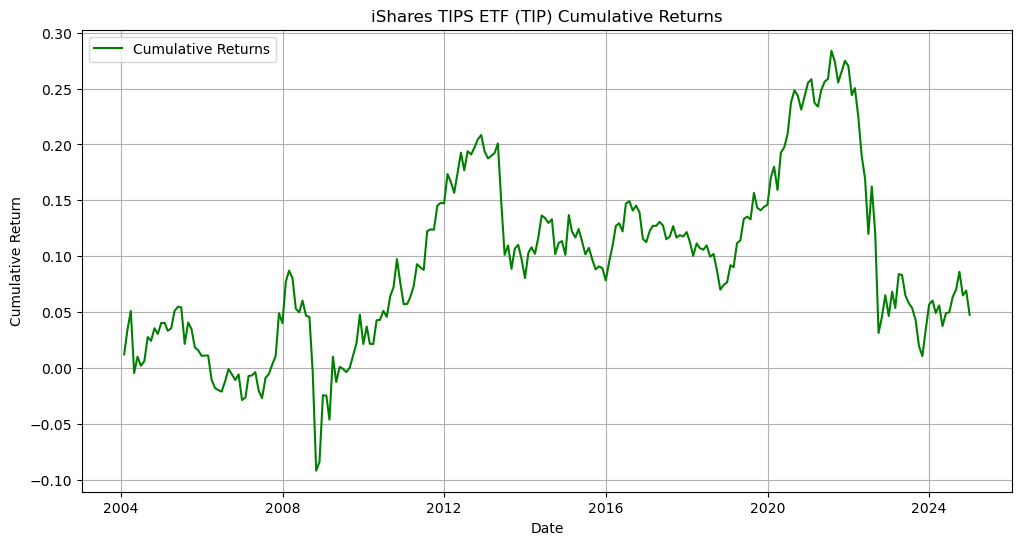

In [185]:
# Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(tip_etf_data.index, tip_etf_data['Cumulative Return'], label='Cumulative Returns', color='green')
plt.title('iShares TIPS ETF (TIP) Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

             GS10  Monthly Return  Cumulative Return
DATE                                                
1979-12-01  10.39             NaN                NaN
1980-01-01  10.80        0.039461           0.039461
1980-02-01  12.41        0.149074           0.194418
1980-03-01  12.75        0.027397           0.227141
1980-04-01  11.47       -0.100392           0.103946


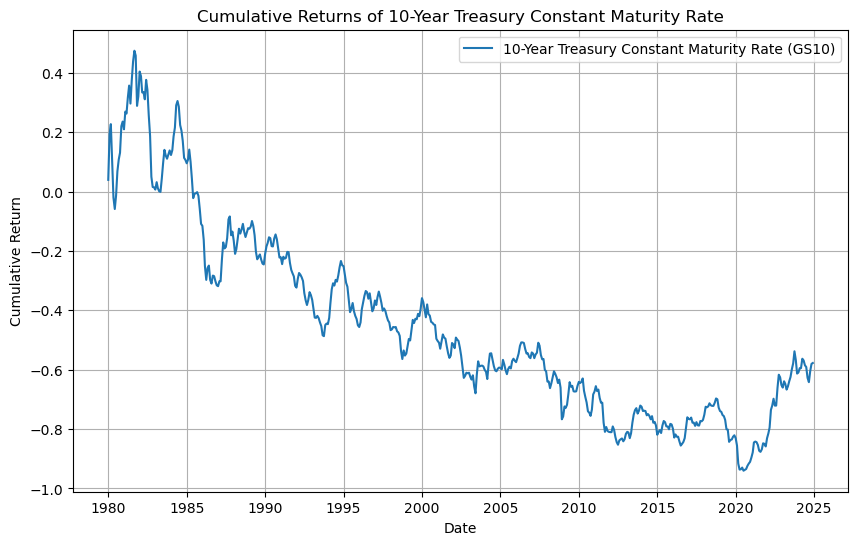

In [186]:
# Define the FRED series ID for the 10-Year Treasury Constant Maturity Rate
series_id = 'GS10'

# Set the date range
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve the data from FRED
gs10_data = web.DataReader(series_id, 'fred', start_date, end_date)

# Ensure the data is sorted by date
gs10_data.sort_index(inplace=True)


# Calculate Monthly Returns based on yield changes
gs10_data['Monthly Return'] = gs10_data[series_id].pct_change()


# Calculate Cumulative Returns
gs10_data['Cumulative Return'] = (1 + gs10_data['Monthly Return']).cumprod() - 1

# Display the first few rows of the data
print(gs10_data.head())

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(gs10_data.index, gs10_data['Cumulative Return'], label='10-Year Treasury Constant Maturity Rate (GS10)')
plt.title('Cumulative Returns of 10-Year Treasury Constant Maturity Rate')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

# Expected Inflation (10Year Breakeven OR Survey?) & Expected Volatility

Expected inflation as in 10 Year Breakeven - The breakeven inflation rate represents a measure of expected inflation derived from 10-Year Treasury Constant Maturity Securities (BC_10YEAR) and 10-Year Treasury Inflation-Indexed Constant Maturity Securities (TC_10YEAR). The latest value implies what market participants expect inflation to be in the next 10 years, on average.

In [187]:
# Download 10-Year Breakeven Inflation Rate data from FRED
breakeven_inflation_data = fred.get_series('T10YIE')
breakeven_inflation_df = pd.DataFrame(breakeven_inflation_data, columns=['Expected Inflation Rate'])
breakeven_inflation_df.index = pd.to_datetime(breakeven_inflation_df.index)

# Display head of the data
breakeven_inflation_df.head()

,Expected Inflation Rate
2003-01-02,1.64
2003-01-03,1.62
2003-01-06,1.63
2003-01-07,1.62
2003-01-08,1.71


University of Michigan Inflation Expectation: Median expected price change next 12 months, Surveys of Consumers.

In [188]:
# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Fetch University of Michigan Inflation Expectations (MICH) from FRED
umich_inflation = web.DataReader("MICH", "fred", start_date, end_date)

# Resample to end-of-month data
umich_inflation = umich_inflation.resample('M').last()

# Rename the column for clarity
umich_inflation.rename(columns={"MICH": "UMich Expected Inflation Rate"}, inplace=True)

# Drop any missing values
umich_inflation.dropna(inplace=True)

# Display the first few rows
print(umich_inflation.head())

            UMich Expected Inflation Rate
DATE                                     
1980-01-31                           10.4
1980-02-29                           10.0
1980-03-31                           10.2
1980-04-30                           10.1
1980-05-31                            8.6


C:\Users\geral\AppData\Local\Temp\ipykernel_15740\2671680920.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  umich_inflation = umich_inflation.resample('M').last()


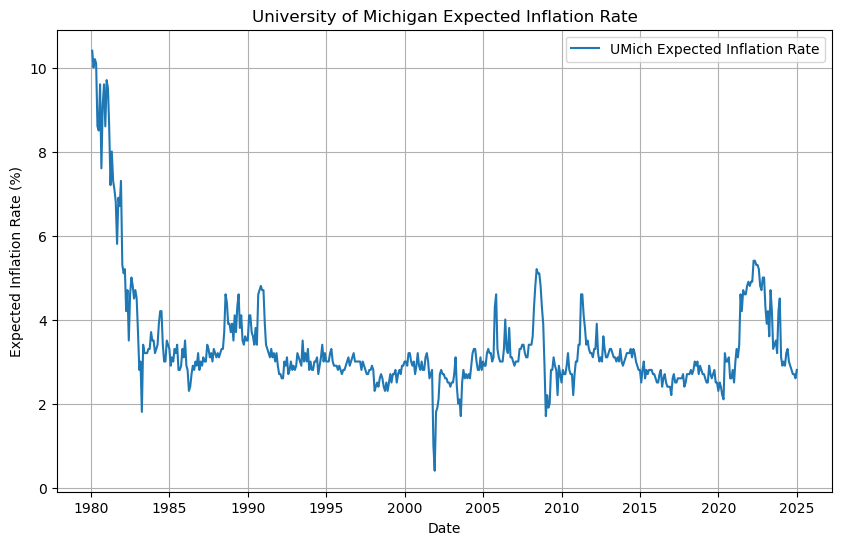

In [189]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(umich_inflation.index, umich_inflation['UMich Expected Inflation Rate'], label='UMich Expected Inflation Rate')
plt.title('University of Michigan Expected Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Expected Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\geral\AppData\Local\Temp\ipykernel_15740\1833242750.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix_data = vix_data.resample('M').last()


            VIX Index
DATE                 
1990-01-31      25.36
1990-02-28      21.99
1990-03-31      19.73
1990-04-30      19.52
1990-05-31      17.37


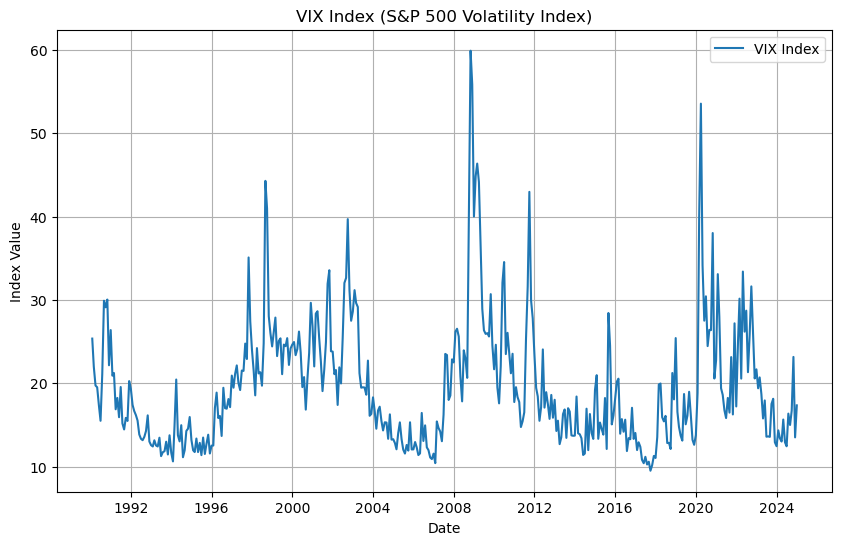

In [190]:
# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Fetch VIX data from FRED
vix_data = web.DataReader("VIXCLS", "fred", start_date, end_date)

# Resample to end-of-month data
vix_data = vix_data.resample('M').last()

# Rename the column for clarity
vix_data.rename(columns={"VIXCLS": "VIX Index"}, inplace=True)

# Drop any missing values
vix_data.dropna(inplace=True)

# Display the first few rows
print(vix_data.head())

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(vix_data.index, vix_data['VIX Index'], label='VIX Index')
plt.title('VIX Index (S&P 500 Volatility Index)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

VIX measures market expectation of near term volatility conveyed by stock index option prices

## Rule of 16

The Cboe® introduced the VIX in 1993 as a weighted measure of the implied volatility (IV)2 of S&P 100® index (OEX) options. The more actively traded S&P 500® index (SPX) options replaced OEX options in the calculation of the VIX in 2003. Since its inception, the VIX has evolved into the preeminent measure of investor fear and overall market volatility.

As investors monitor the VIX on a daily and weekly basis, they're simply watching a number that represents the IV of SPX options. Without getting into a long math discussion involving square roots, let's simplify an interesting aspect of the VIX, which is the number 16 (or more precisely, 15.87). It's the square root of 252 (the number of trading days in a year). Rounding 15.87 to 16 is where the rule of 16 gets its name.

Let's walk through some hypotheticals. According to the rule of 16, if the VIX is trading at 16, then the SPX is estimated to see average daily moves up or down of 1% (because 16/16 = 1). If the VIX is at 24, the daily moves might be around 1.5%, and at 32, the rule of 16 says the SPX might see 2% daily moves.

The options rule of 16 works the other way, too—you can "annualize" a daily reading by multiplying it by 16. For example, suppose a stock has had a few moves of 1.8%, and you think a 1.8% daily move might accurately capture the stock's inherent volatility. If so, you'd be expecting an annualized volatility level of 1.8 x 16 = 28.8%. Because volatility is an important variable of options pricing models, comparing your expectation for an underlying security's volatility to the current IV might indicate whether you believe an option is overpriced, underpriced, or fairly priced.

C:\Users\geral\AppData\Local\Temp\ipykernel_15740\2370008060.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix_monthly = vix_daily['Implied Daily Volatility'].resample('M').last()


DATE
1990-01-31    7.263382
1990-02-28    6.298177
1990-03-31    5.650889
1990-04-30    5.590742
1990-05-31    4.974959
Freq: ME, Name: Implied Daily Volatility, dtype: float64


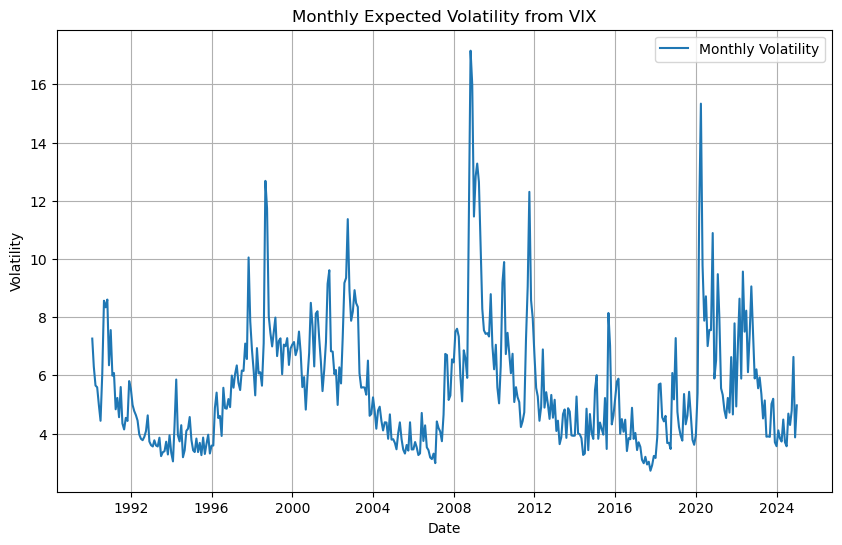

In [191]:
# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Fetch daily VIX data from FRED
vix_daily = web.DataReader("VIXCLS", "fred", start_date, end_date)

# Drop any missing values
vix_daily.dropna(inplace=True)

# Convert the VIX to implied daily volatility by dividing by 16
vix_daily['Implied Daily Volatility'] = vix_daily['VIXCLS'] / 16

# Resample to end-of-month data
vix_monthly = vix_daily['Implied Daily Volatility'].resample('M').last()

# Calculate the monthly volatility by scaling the daily volatility
# Monthly volatility = Daily volatility * sqrt(number of trading days in a month)
# Approximate number of trading days in a month = 21
vix_monthly = vix_monthly * (21 ** 0.5)

# Display the first few rows of the monthly volatility
print(vix_monthly.head())

# Plot the monthly volatility
plt.figure(figsize=(10, 6))
plt.plot(vix_monthly.index, vix_monthly, label='Monthly Volatility')
plt.title('Monthly Expected Volatility from VIX')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

.MOVE         HIGH  MOVE Index    LOW   OPEN
Date                                        
2019-10-31   80.25       65.88  63.32  79.86
2019-11-30   69.82       56.57  56.57  57.28
2019-12-31   67.29       58.28  53.41  59.42
2020-01-31   72.98       72.98  49.67  58.28
2020-02-29  109.67      109.67  61.24  72.81


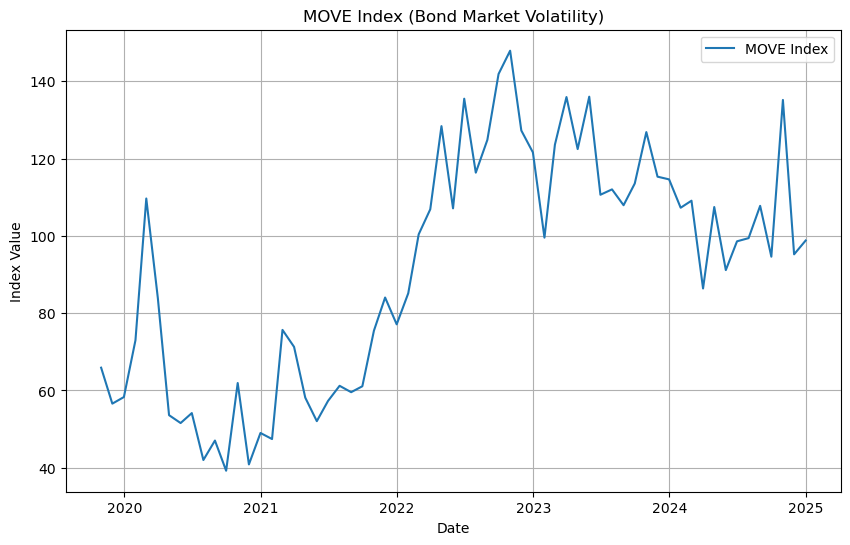

In [192]:
# Define the ticker symbol for the MOVE Index and parameters
ticker = '.MOVE'
start_date = '1979-12-31'
end_date = '2024-12-31'

# Retrieve MOVE Index data from Eikon
try:
    move_data = ek.get_timeseries(ticker, start_date=start_date, end_date=end_date, interval='monthly')
    
    # Rename the column for clarity
    move_data.rename(columns={"CLOSE": "MOVE Index"}, inplace=True)

    # Drop any missing values
    move_data.dropna(inplace=True)

    # Display the first few rows
    print(move_data.head())

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(move_data.index, move_data['MOVE Index'], label='MOVE Index')
    plt.title('MOVE Index (Bond Market Volatility)')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"An error occurred: {e}")

# Summary Statistics

Tips Data Still Wrong...

In [262]:
# List of dataframes and corresponding names for the datasets
data_frames = [
    sp500_df, russell2000_data, nasdaq_data, FTSE_data, dax_data, stoxx_data, nikkei_data,
    gold_data, oil_data, gs10_data, tip_etf_data, dfii10_data, spg_data, realty_income_data, USD_EUR_data, 
    USD_JPY_data, USD_CHF_data
]

dataset_names = [
    "S&P 500", "Russell 2000", "NASDAQ", "FTSE", "DAX", "STOXX", "Nikkei", 
    "Gold", "Oil", "10 Year Treasury Note", "TIPS ETF", "10 Year Inflation-Indexed Treasury", "REIT SPG", "REIT O",
    "USD/EUR", "USD/JPY", "USD/CHF"
]

# Initialize an empty list to store summary statistics
summary_stats = []

# Iterate through each dataframe and corresponding name
for df, name in zip(data_frames, dataset_names):
    if 'Monthly Return' in df.columns:  # Check if 'Monthly Return' exists
        stats = df['Monthly Return'].describe()  # Generate summary statistics for Monthly Return
        summary_stats.append({
            "Dataset": name,
            "Count": stats['count'],
            "Mean": stats['mean'],
            "Std Dev": stats['std'],
            "Min": stats['min'],
            "25%": stats['25%'],
            "50% (Median)": stats['50%'],
            "75%": stats['75%'],
            "Max": stats['max']
        })
    else:
        print(f"Warning: 'Monthly Return' column missing for {name}")

# Convert the summary statistics list to a DataFrame
summary_stats_df = pd.DataFrame(summary_stats)

# Display the summary statistics table
print("\nSummary Statistics for Monthly Returns:")
print(summary_stats_df)

# Save the summary statistics to a CSV file
summary_stats_df.to_csv("monthly_return_summary_statistics.csv", index=False)

print("\nSummary statistics have been saved to 'monthly_return_summary_statistics.csv'.")


Summary Statistics for Monthly Returns:
                               Dataset  Count          Mean       Std Dev  \
0                              S&P 500  540.0  8.401026e-03  4.379131e-02   
1                         Russell 2000  540.0  8.534014e-03  5.713203e-02   
2                               NASDAQ  537.0  1.119280e-02  6.035837e-02   
3                                 FTSE  491.0  5.089753e-03  4.264730e-02   
4                                  DAX  444.0  8.455916e-03  5.797659e-02   
5                                STOXX  444.0  5.044239e-03  5.259012e-02   
6                               Nikkei  468.0  4.089205e-03  5.805067e-02   
7                                 Gold  540.0  4.240285e-03  4.950071e-02   
8                                  Oil  489.0  7.291995e-03  1.057983e-01   
9                10 Year Treasury Note  540.0  6.289739e-04  6.575333e-02   
10                            TIPS ETF  252.0  3.358766e-04  1.734802e-02   
11  10 Year Inflation-Indexed Treas

In [194]:
import pandas as pd

# List of dataframes
data_frames = [
    sp500_df, russell2000_data, nasdaq_data, FTSE_data, dax_data, stoxx_data, nikkei_data,
    gold_data, oil_data, gs10_data, tip_etf_data, dfii10_data, spg_data, realty_income_data, USD_EUR_data, 
    USD_JPY_data, USD_CHF_data
]

# List of corresponding names for the datasets
dataset_names = [
    "S&P 500", "Russell 2000", "NASDAQ", "FTSE", "DAX", "STOXX", "Nikkei", 
    "Gold", "Oil", "10 Year Treasury Note", "TIPS ETF", "10 Year Inflation-Indexed Treasury", "REIT SPG", "REIT O",
    "USD/EUR", "USD/JPY", "USD/CHF"
]

# Initialize an empty dictionary to store the average annualized returns per 5-year interval for each dataset
average_annualized_returns_per_interval = {}

# Iterate through each dataframe and corresponding name
for df, name in zip(data_frames, dataset_names):
    # Ensure the index is in datetime format (if it's not already)
    df.index = pd.to_datetime(df.index)

    # Check if 'Monthly Return' column exists in the DataFrame
    if 'Monthly Return' in df.columns:
        # Create 5-year intervals starting from 1940
        start_year = 1980
        df['5-Year Interval'] = ((df.index.year - start_year) // 5) * 5 + start_year

        # Group by 5-year intervals and calculate the average monthly return per interval
        avg_monthly_return = df.groupby('5-Year Interval')['Monthly Return'].mean()

        # Annualize the average monthly return using the formula
        annualized_return = (1 + avg_monthly_return) ** 12 - 1

        # Convert to percentage
        annualized_return_percentage = annualized_return * 100

        # Store the result in the dictionary
        average_annualized_returns_per_interval[name] = annualized_return_percentage
    else:
        print(f"Warning: 'Monthly Return' column not found in {name} DataFrame.")

# Combine the results into a single DataFrame for display
annualized_interval_summary = pd.DataFrame(average_annualized_returns_per_interval)

# Transpose the DataFrame so that intervals are rows and datasets are columns
annualized_interval_summary_transposed = annualized_interval_summary.transpose()

# Format the values to show percentages with 2 decimal places
annualized_interval_summary_transposed = annualized_interval_summary_transposed.round(2)

# Display the resulting transposed table
print(annualized_interval_summary_transposed)

# Save the summary to a CSV file
annualized_interval_summary_transposed.to_csv("average_annualized_nominal_returns_5_year_intervals.csv")

print("\nAverage annualized nominal returns have been saved to 'average_annualized_nominal_returns_5_year_intervals.csv'.")

5-Year Interval                          1975       1980       1985  \
S&P 500                             22.083595  10.346957  18.003589   
Russell 2000                             <NA>  14.960692  13.428318   
NASDAQ                                   <NA>  16.098356  15.262032   
FTSE                                     <NA>  19.272796  16.982027   
DAX                                      <NA>       <NA>  35.127332   
STOXX                                    <NA>       <NA>   8.965875   
Nikkei                                    NaN        NaN  32.924397   
Gold                                     <NA>  -5.895458   6.625068   
Oil                                      <NA>  -5.083113   3.871463   
10 Year Treasury Note                     NaN   3.553979   -6.53026   
TIPS ETF                                 <NA>       <NA>       <NA>   
10 Year Inflation-Indexed Treasury        NaN        NaN        NaN   
REIT SPG                                 <NA>       <NA>       <NA>   
REIT O

In [215]:
msci_world.head()

.dMIWO00000PUS,Monthly Returns,Cumulative Returns,Historical Volatility,GARCH Volatility,Hist_Volatility,GARCH_Volatility
Date,,,,,,
1979-12-31,2.361082,0.07214,11.514766,4.219173,11.514766,14.615644
1980-01-31,5.713233,0.133394,12.518937,3.982763,12.518937,13.796696
1980-02-29,-0.247419,0.13059,12.144582,4.162928,12.144582,14.420805
1980-03-31,-11.059465,0.005553,16.723001,3.914247,16.723001,13.559350
1980-04-30,6.199485,0.067892,17.881196,5.736291,17.881196,19.871096


In [232]:
import pandas as pd

# Initialize an empty list to store summary statistics
summary_stats = []

# Process CPI data for inflation rates
if 'Monthly Inflation Rate' in cpi_df.columns and 'YoY Inflation Rate' in cpi_df.columns:
    stats_monthly_inflation = cpi_df['Monthly Inflation Rate'].describe()
    stats_yoy_inflation = cpi_df['YoY Inflation Rate'].describe()
    summary_stats.append({
        "Dataset": "CPI Monthly Inflation Rate",
        "Count": stats_monthly_inflation['count'],
        "Mean": stats_monthly_inflation['mean'],
        "Std Dev": stats_monthly_inflation['std'],
        "Min": stats_monthly_inflation['min'],
        "25%": stats_monthly_inflation['25%'],
        "50% (Median)": stats_monthly_inflation['50%'],
        "75%": stats_monthly_inflation['75%'],
        "Max": stats_monthly_inflation['max']
    })
    summary_stats.append({
        "Dataset": "CPI YoY Inflation Rate",
        "Count": stats_yoy_inflation['count'],
        "Mean": stats_yoy_inflation['mean'],
        "Std Dev": stats_yoy_inflation['std'],
        "Min": stats_yoy_inflation['min'],
        "25%": stats_yoy_inflation['25%'],
        "50% (Median)": stats_yoy_inflation['50%'],
        "75%": stats_yoy_inflation['75%'],
        "Max": stats_yoy_inflation['max']
    })
else:
    print("Warning: 'Monthly Inflation Rate' or 'YoY Inflation Rate' column not found in CPI DataFrame.")

# Process MSCI World data for volatilities
if 'Historical Volatility' in msci_world.columns and 'GARCH Volatility' in msci_world.columns:
    stats_historical_vol = msci_world['Historical Volatility'].describe()
    stats_garch_vol = msci_world['GARCH Volatility'].describe()
    summary_stats.append({
        "Dataset": "MSCI World Historical Volatility",
        "Count": stats_historical_vol['count'],
        "Mean": stats_historical_vol['mean'],
        "Std Dev": stats_historical_vol['std'],
        "Min": stats_historical_vol['min'],
        "25%": stats_historical_vol['25%'],
        "50% (Median)": stats_historical_vol['50%'],
        "75%": stats_historical_vol['75%'],
        "Max": stats_historical_vol['max']
    })
    summary_stats.append({
        "Dataset": "MSCI World GARCH Volatility",
        "Count": stats_garch_vol['count'],
        "Mean": stats_garch_vol['mean'],
        "Std Dev": stats_garch_vol['std'],
        "Min": stats_garch_vol['min'],
        "25%": stats_garch_vol['25%'],
        "50% (Median)": stats_garch_vol['50%'],
        "75%": stats_garch_vol['75%'],
        "Max": stats_garch_vol['max']
    })
else:
    print("Warning: 'Historical Volatility' or 'GARCH Volatility' column not found in MSCI World DataFrame.")

# Convert the summary statistics list to a DataFrame
summary_stats_df = pd.DataFrame(summary_stats)

# Display the summary statistics table
print("\nSummary Statistics for Inflation and Volatilities:")
print(summary_stats_df)

# Save the summary statistics to a CSV file
summary_stats_df.to_csv("inflation_volatility_summary_statistics.csv", index=False)

print("\nSummary statistics have been saved to 'inflation_volatility_summary_statistics.csv'.")


Summary Statistics for Inflation and Volatilities:
                            Dataset  Count       Mean   Std Dev       Min  \
0        CPI Monthly Inflation Rate  540.0   0.263434  0.297871 -1.770548   
1            CPI YoY Inflation Rate  540.0   3.336555  2.488589 -1.958761   
2  MSCI World Historical Volatility  540.0  14.013958  5.188093  2.939421   
3       MSCI World GARCH Volatility  540.0   4.270184  0.974659  2.922404   

        25%  50% (Median)        75%        Max  
0  0.123571      0.244648   0.386348   1.430429  
1  1.910096      2.837368   3.973858  14.592275  
2  9.440960     13.944172  16.910335  34.039679  
3  3.527401      4.121555   4.695656   9.275172  

Summary statistics have been saved to 'inflation_volatility_summary_statistics.csv'.


In [275]:
import pandas as pd
import numpy as np
from arch import arch_model
from statsmodels.tsa.stattools import acf

# Assuming cpi_df and msci_world DataFrames are already loaded

# Calculate Historical Volatility and GARCH Volatility if not already present
if 'Historical Volatility' not in msci_world.columns:
    msci_world['Historical Volatility'] = msci_world['Monthly Return'].rolling(window=12).std() * np.sqrt(12) * 100

if 'GARCH Volatility' not in msci_world.columns:
    garch_model = arch_model(msci_world['Monthly Return'], vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')
    msci_world['GARCH Volatility'] = garch_fit.conditional_volatility

# Define the number of lags for the ACF calculation
num_lags = 13

# Calculate autocorrelation function and save results in a DataFrame
def calculate_acf(series, lags):
    acf_values = acf(series.dropna(), nlags=lags)
    return pd.Series(acf_values, index=range(lags + 1))

# Calculate autocorrelation for macroeconomic variables
acf_monthly_inflation = calculate_acf(cpi_df['Monthly Inflation Rate'], num_lags)
acf_historical_vol = calculate_acf(msci_world['Historical Volatility'], num_lags)
acf_garch_vol = calculate_acf(msci_world['GARCH Volatility'], num_lags)

# Create a DataFrame to store the results
acf_results = pd.DataFrame({
    'Lag': range(num_lags + 1),
    'Monthly Inflation Rate': acf_monthly_inflation,
    'Historical Volatility': acf_historical_vol,
    'GARCH Volatility': acf_garch_vol
})

# Calculate autocorrelation for each asset
assets = {
    "SP500": sp500_df,
    "Russell 2000": russell2000_data,
    "NASDAQ": nasdaq_data,
    "FTSE": FTSE_data,
    "DAX": dax_data,
    "STOXX": stoxx_data,
    "Nikkei": nikkei_data,
    "Gold": gold_data,
    "Oil": oil_data,
    "10 Year Treasury Note": gs10_data,
    "TIPS ETF": tip_etf_data,
    "10 Year Inflation-Indexed Treasury": dfii10_data,
    "REIT SPG": spg_data,
    "REIT O": realty_income_data,
    "USD/EUR": USD_EUR_data,
    "USD/JPY": USD_JPY_data,
    "USD/CHF": USD_CHF_data
}

for asset_name, asset_df in assets.items():
    acf_asset = calculate_acf(asset_df['Monthly Return'], num_lags)
    acf_results[asset_name] = acf_asset

# Reshape the DataFrame to have a more structured format
acf_results_melted = acf_results.melt(id_vars=['Lag'], var_name='Variable', value_name='Autocorrelation')

# Pivot the DataFrame to get the desired format
acf_results_pivot = acf_results_melted.pivot(index='Variable', columns='Lag', values='Autocorrelation')

# Display the results
print(acf_results_pivot)

# Save the results to a CSV file
acf_results_pivot.to_csv("acf_inflation_volatility_assets.csv")

print("\nAutocorrelation results have been saved to 'acf_inflation_volatility_assets.csv'.")

Lag                                  0         1         2         3   \
Variable                                                                
10 Year Inflation-Indexed Treasury  1.0 -0.003831 -0.003846 -0.003860   
10 Year Treasury Note               1.0  0.333657  0.013802  0.025454   
DAX                                 1.0  0.021671 -0.042262  0.041844   
FTSE                                1.0 -0.004842 -0.079273 -0.012151   
GARCH Volatility                    1.0  0.893979  0.787051  0.688296   
Gold                                1.0 -0.079255 -0.075995  0.007094   
Historical Volatility               1.0  0.952730  0.894639  0.831387   
Monthly Inflation Rate              1.0  0.556613  0.259795  0.210275   
NASDAQ                              1.0  0.086447 -0.009701 -0.004130   
Nikkei                              1.0  0.044836 -0.002875  0.041464   
Oil                                 1.0  0.130696 -0.094388 -0.028823   
REIT O                              1.0 -0.075786 -

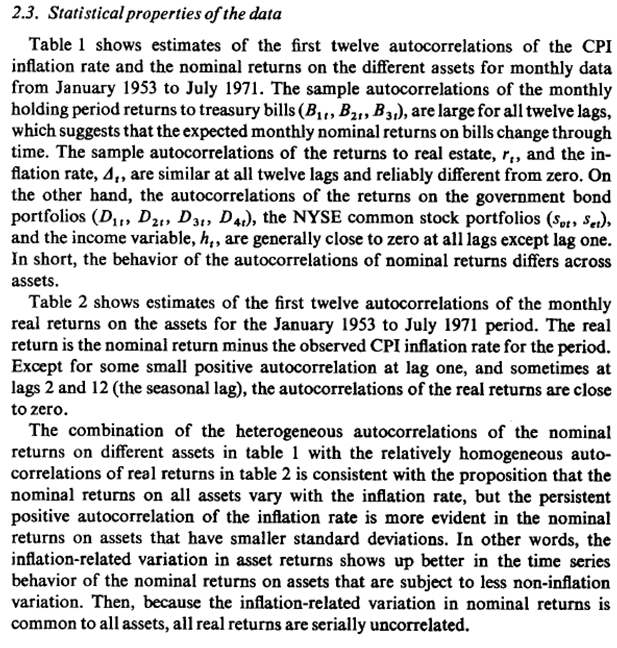

# ARIMA Model to Forecast Inflation

Sure, let's discuss ARIMA models.

### ARIMA Model Overview

ARIMA stands for AutoRegressive Integrated Moving Average. It is a popular time series forecasting method that combines three components:
1. **AutoRegressive (AR) part**: This part involves regressing the variable on its own lagged (past) values. The order of the AR term is denoted by `p`.
2. **Integrated (I) part**: This part involves differencing the data to make it stationary. The order of differencing is denoted by `d`.
3. **Moving Average (MA) part**: This part involves modeling the error term as a linear combination of error terms occurring contemporaneously and at various times in the past. The order of the MA term is denoted by `q`.

### ARIMA Model Notation

An ARIMA model is typically denoted as ARIMA(p, d, q), where:
- `p` is the number of lag observations included in the model (the number of lagged terms).
- `d` is the number of times that the raw observations are differenced.
- `q` is the size of the moving average window (the number of lagged forecast errors).

### Steps to Build an ARIMA Model

1. **Visualize the Time Series**: Plot the time series data to understand its structure and identify any trends or seasonality.
2. **Make the Time Series Stationary**: Use differencing to remove trends and seasonality, making the time series stationary.
3. **Determine the Order of AR and MA Terms**: Use autocorrelation function (ACF) and partial autocorrelation function (PACF) plots to determine the appropriate values of `p` and `q`.
4. **Fit the ARIMA Model**: Use statistical software or libraries (e.g., `statsmodels` in Python) to fit the ARIMA model to the data.
5. **Evaluate the Model**: Check the residuals of the model to ensure they resemble white noise. Use metrics like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) to compare models.
6. **Forecast**: Use the fitted ARIMA model to make forecasts.

### Key Points to Consider

- **Stationarity**: The ARIMA model assumes that the time series is stationary. If the series is not stationary, you need to difference it until it becomes stationary.
- **Model Selection**: Use ACF and PACF plots to identify the appropriate values of `p` and `q`. The AIC and BIC metrics can help compare different models.
- **Residual Analysis**: After fitting the model, analyze the residuals to ensure they resemble white noise (i.e., they are uncorrelated and have a constant mean and variance).

### Extensions of ARIMA

- **Seasonal ARIMA (SARIMA)**: Extends ARIMA to handle seasonality by adding seasonal terms.
- **Auto ARIMA**: Automatically selects the best ARIMA model by optimizing the parameters `p`, `d`, and `q`.

You can apply the ARIMA model to any time series data where you want to understand the underlying patterns and make forecasts. In the context of your dissertation, here are some potential applications of the ARIMA model:

1. Forecasting Macroeconomic Variables
Monthly Inflation Rate: Use the ARIMA model to forecast future monthly inflation rates based on historical data.
Historical Volatility: Apply the ARIMA model to forecast future historical volatility of an asset or index.
GARCH Volatility: Although GARCH models are specifically designed for volatility, you can still use ARIMA models to forecast the volatility series if needed.
2. Forecasting Asset Returns
Individual Asset Returns: Use the ARIMA model to forecast future returns of individual assets such as SP500, Russell 2000, NASDAQ, FTSE, DAX, etc.
Portfolio Returns: If you have a portfolio of assets, you can use the ARIMA model to forecast the overall portfolio returns.
3. Analyzing and Forecasting Expected Inflation and Volatility
Expected Inflation (e.g., UMich Expected Inflation Rate): Use the ARIMA model to forecast future expected inflation rates.
Expected Volatility (e.g., VIX): Apply the ARIMA model to forecast future expected volatility.
Example: Applying ARIMA to Monthly Inflation Rate
Here is an example of how to apply the ARIMA model to forecast the Monthly Inflation Rate:

In [ ]:
# Load your time series data
# Example: Assume 'cpi_df' is a DataFrame containing the Monthly Inflation Rate
monthly_inflation_rate = cpi_df['Monthly Inflation Rate'].dropna()

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(monthly_inflation_rate)
plt.title('Monthly Inflation Rate')
plt.show()

# Make the time series stationary (if necessary)
# Example: Differencing the data
monthly_inflation_diff = monthly_inflation_rate.diff().dropna()

# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(monthly_inflation_diff, lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(monthly_inflation_diff, lags=20, ax=plt.gca())
plt.show()

# Fit the ARIMA model
# Example: ARIMA(1, 1, 1)
model = ARIMA(monthly_inflation_rate, order=(1, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Plot the residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Plot ACF of residuals to check for white noise
plot_acf(residuals, lags=20)
plt.show()

# Forecast using the fitted model
forecast = model_fit.forecast(steps=12)  # Forecasting the next 12 months
print(forecast)

## Regressions



Lagged Variables:

Besides the previous month's inflation rate, you could include other lagged variables (e.g., 2 months, 3 months) to see if they have any predictive power.
Multiple Regression:

Include multiple independent variables in your regression model, such as both the current and previous month's inflation rates, or other economic indicators.
Interaction Terms:

Include interaction terms to see if the relationship between inflation and returns changes under different conditions.
Rolling Window Regression:

Perform rolling window regressions to see how the relationship between inflation and returns changes over time.
Different Time Horizons:

Perform regressions using different time horizons for returns (e.g., weekly, quarterly) to see if the relationship holds at different frequencies.
Volatility Measures:

Include measures of volatility (e.g., GARCH volatility) as independent variables to see if they have any explanatory power.

Given the assets, macroeconomic variables, expected inflation data, expected volatility (VIX), and factor models, here are some regressions that could be worth doing:

Asset Returns vs. Macroeconomic Variables:

Regress the returns of each asset on the YoY Inflation Rate (lagged), Historical Volatility (lagged), and GARCH Volatility (lagged).
This will help you understand how macroeconomic variables impact the returns of each asset.
Asset Returns vs. Expected Inflation and Expected Volatility:

Regress the returns of each asset on the expected inflation data (e.g., UMich Expected Inflation Rate) and expected volatility (VIX).
This will help you understand how expectations about inflation and volatility impact the returns of each asset.
Asset Returns vs. Factor Models:

Perform CAPM regression: Regress the returns of each asset on the market excess returns (Mkt-RF).
Perform Fama-French 3-Factor Model regression: Regress the returns of each asset on the three Fama-French factors (Mkt-RF, SMB, HML).
Perform Carhart 4-Factor Model regression: Regress the returns of each asset on the four Carhart factors (Mkt-RF, SMB, HML, Mom).
Perform Fama-French 5-Factor Model regression: Regress the returns of each asset on the five Fama-French factors (Mkt-RF, SMB, HML, RMW, CMA).
Perform Fama-French 5-Factor Model with Momentum regression: Regress the returns of each asset on the five Fama-French factors plus the momentum factor (Mkt-RF, SMB, HML, RMW, CMA, Mom).
These regressions will help you understand how different factors explain the returns of each asset.

## FACTOR MODELS MAINLY FOR ROBUSTNESS

In [269]:
# Define the start and end dates for the data
start_date = '1980-01-31'
end_date = '2024-12-31'

# Fetch Fama-French 3-Factor data (monthly)
ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)[0]
ff3.columns = ['Mkt-RF', 'SMB', 'HML', 'RF']

# Fetch Carhart 4-Factor data (monthly)
carhart = web.DataReader('F-F_Momentum_Factor', 'famafrench', start_date, end_date)[0]
carhart.columns = ['Mom']

# Merge Carhart 4-Factor data with Fama-French 3-Factor data
carhart_merged = ff3.join(carhart, how='inner')

# Fetch Fama-French 5-Factor data (monthly)
ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start_date, end_date)[0]
ff5.columns = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

# Display the first few rows of each dataset
print("Fama-French 3-Factor Model Data:")
print(ff3.head())

print("\nCarhart 4-Factor Model Data:")
print(carhart_merged.head())

print("\nFama-French 5-Factor Model Data:")
print(ff5.head())

C:\Users\geral\AppData\Local\Temp\ipykernel_15740\845649574.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)[0]
C:\Users\geral\AppData\Local\Temp\ipykernel_15740\845649574.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)[0]
C:\Users\geral\AppData\Local\Temp\ipykernel_15740\845649574.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  carhart = web.DataRe

Fama-French 3-Factor Model Data:
         Mkt-RF   SMB   HML    RF
Date                             
1980-01    5.51  1.62  1.75  0.80
1980-02   -1.22 -1.85  0.61  0.89
1980-03  -12.90 -6.64 -1.01  1.21
1980-04    3.97  1.05  1.06  1.26
1980-05    5.26  2.13  0.38  0.81

Carhart 4-Factor Model Data:
         Mkt-RF   SMB   HML    RF   Mom
Date                                   
1980-01    5.51  1.62  1.75  0.80  7.55
1980-02   -1.22 -1.85  0.61  0.89  7.88
1980-03  -12.90 -6.64 -1.01  1.21 -9.55
1980-04    3.97  1.05  1.06  1.26 -0.43
1980-05    5.26  2.13  0.38  0.81 -1.12

Fama-French 5-Factor Model Data:
         Mkt-RF   SMB   HML   RMW   CMA    RF
Date                                         
1980-01    5.51  1.83  1.75 -1.70  1.64  0.80
1980-02   -1.22 -1.57  0.61  0.04  2.68  0.89
1980-03  -12.90 -6.93 -1.01  1.46 -1.19  1.21
1980-04    3.97  1.05  1.06 -2.10  0.29  1.26
1980-05    5.26  2.11  0.38  0.34 -0.31  0.81


C:\Users\geral\AppData\Local\Temp\ipykernel_15740\845649574.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start_date, end_date)[0]
C:\Users\geral\AppData\Local\Temp\ipykernel_15740\845649574.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start_date, end_date)[0]


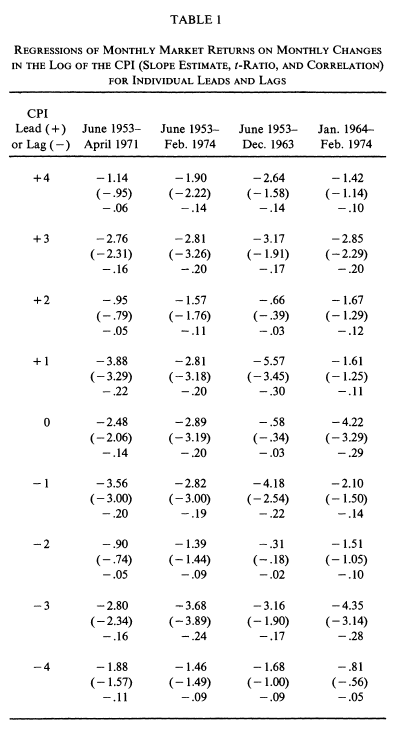

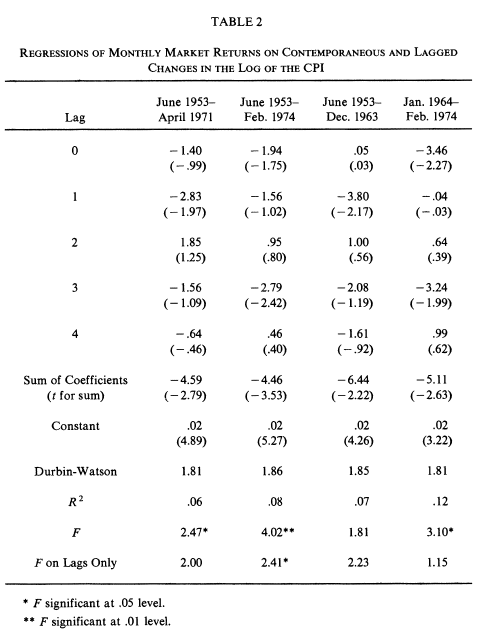

In [ ]:
# Example: Regressing SP500 returns on macroeconomic variables
y = sp500_df['Monthly Return']
X_macro = pd.concat([cpi_df['YoY Inflation Rate'].shift(1), msci_world['Historical Volatility'].shift(1), msci_world['GARCH Volatility'].shift(1)], axis=1)
X_macro = sm.add_constant(X_macro.dropna())
y_macro = y.loc[X_macro.index]

# see the shift 1 command, should be also for other periods, 2 months, 3 months, etc...